Objective: Predict prices for test (test.csv) dataset based on model build from train (train.csv) dataset  

Evaluation metric: "The RMSE between log of Saleprice and log of prediction". Need to convert salesprice to log value first. However seems that BoxCox does a better job here. For my testing E will remove BoxCox, but may want to put it back for the final submissions. Maybe one with boxcox1p() and one with log().

Original competition (explains the evaluation metric): https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation. My work is paying off, my submission on that site is #3 out of 38000, top .0001%

Original notebook source: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard  

Reference for good ideas: https://towardsdatascience.com/tricks-i-used-to-succeed-on-a-famous-kaggle-competition-adaa16c09f22

Original default score was .11543, new best score is 0.11353

Stacked and Ensembled Regressions to predict House Prices  
How to Kaggle: https://www.youtube.com/watch?v=GJBOMWpLpTQ

References for stacking and ensembling:
https://www.kaggle.com/getting-started/18153
https://developer.ibm.com/technologies/artificial-intelligence/articles/stack-machine-learning-models-get-better-results

Donald S  
July 2020  

Need to submit every 2 months as the leaderboard will rollover after this 2 month period

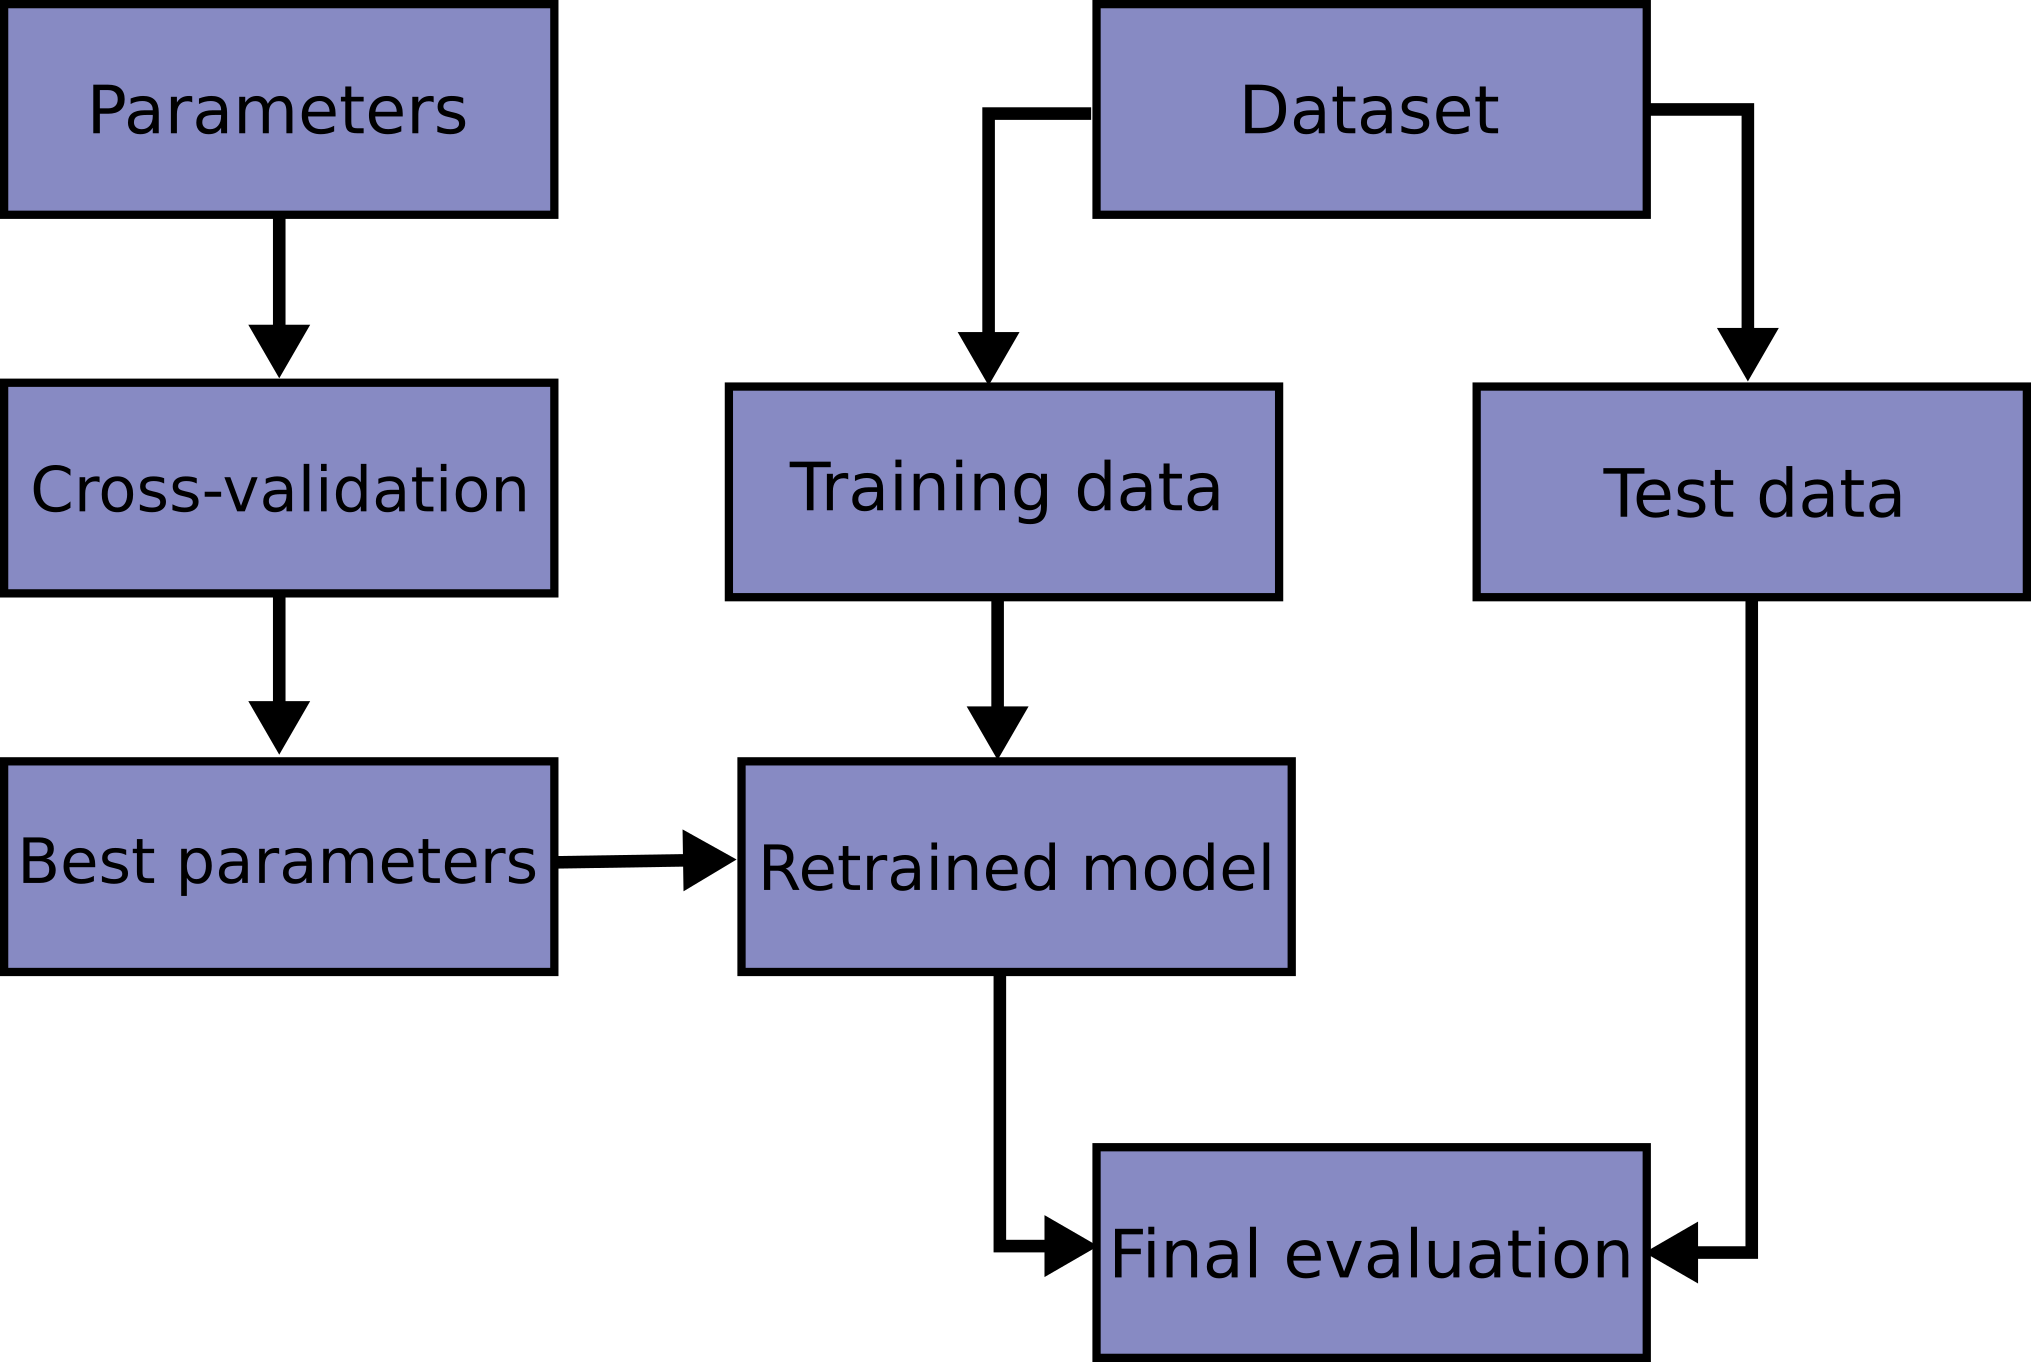

We will be using Ensembling methods in this notebook. I will only create one dataset for all models to use, but you can create multiple datasets, each to be used by a different set of models, depending on your use case.

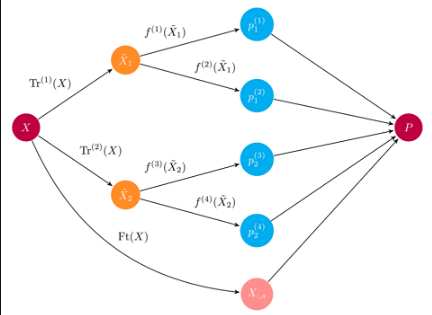

In [1]:
#import some necessary libraries
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import time

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["ls", "-rlt", "../StackedRegression"]).decode("utf8")) #check the files available in the directory
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

StartTime = datetime.datetime.now()

In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [3]:
#train = pd.read_csv('input/train.csv')
#test = pd.read_csv('input/test.csv')

# default competition
competition = 'SR' # StackedRegression

try:
    a = check_output(["ls", "../input"]).decode("utf8") # new Kaggle competition
except:
    a=''
finally:
    print('')
try:
    b = check_output(["ls", "-rlt", "../StackedRegression"]).decode("utf8")
except:
    b=''
finally:
    print('')    
#if (competition == 'SRP_2'): # Stacked Regressions Part 2
if (len(a) > 0): # new competition
    competition = 'SR'
    train = pd.read_csv('../input/home-data-for-ml-course/train.csv')#,index_col='Id')
    test = pd.read_csv('../input/home-data-for-ml-course/test.csv')#,index_col='Id')
elif (len(b)): # run locally
    competition = 'SR'
    train = pd.read_csv('input/train.csv')
    test = pd.read_csv('input/test.csv')
else: # old competition
    competition = 'SRP_2'
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')

In [4]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#Data Processing

##Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


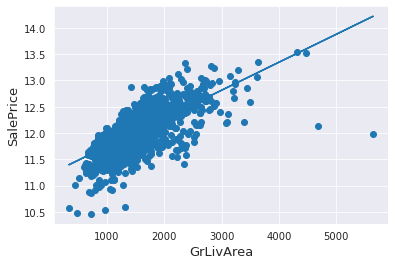

In [6]:
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice']
ax.scatter(x = train['GrLivArea'], y = np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)

plt.show()


Edit: Look for fliers in other columns

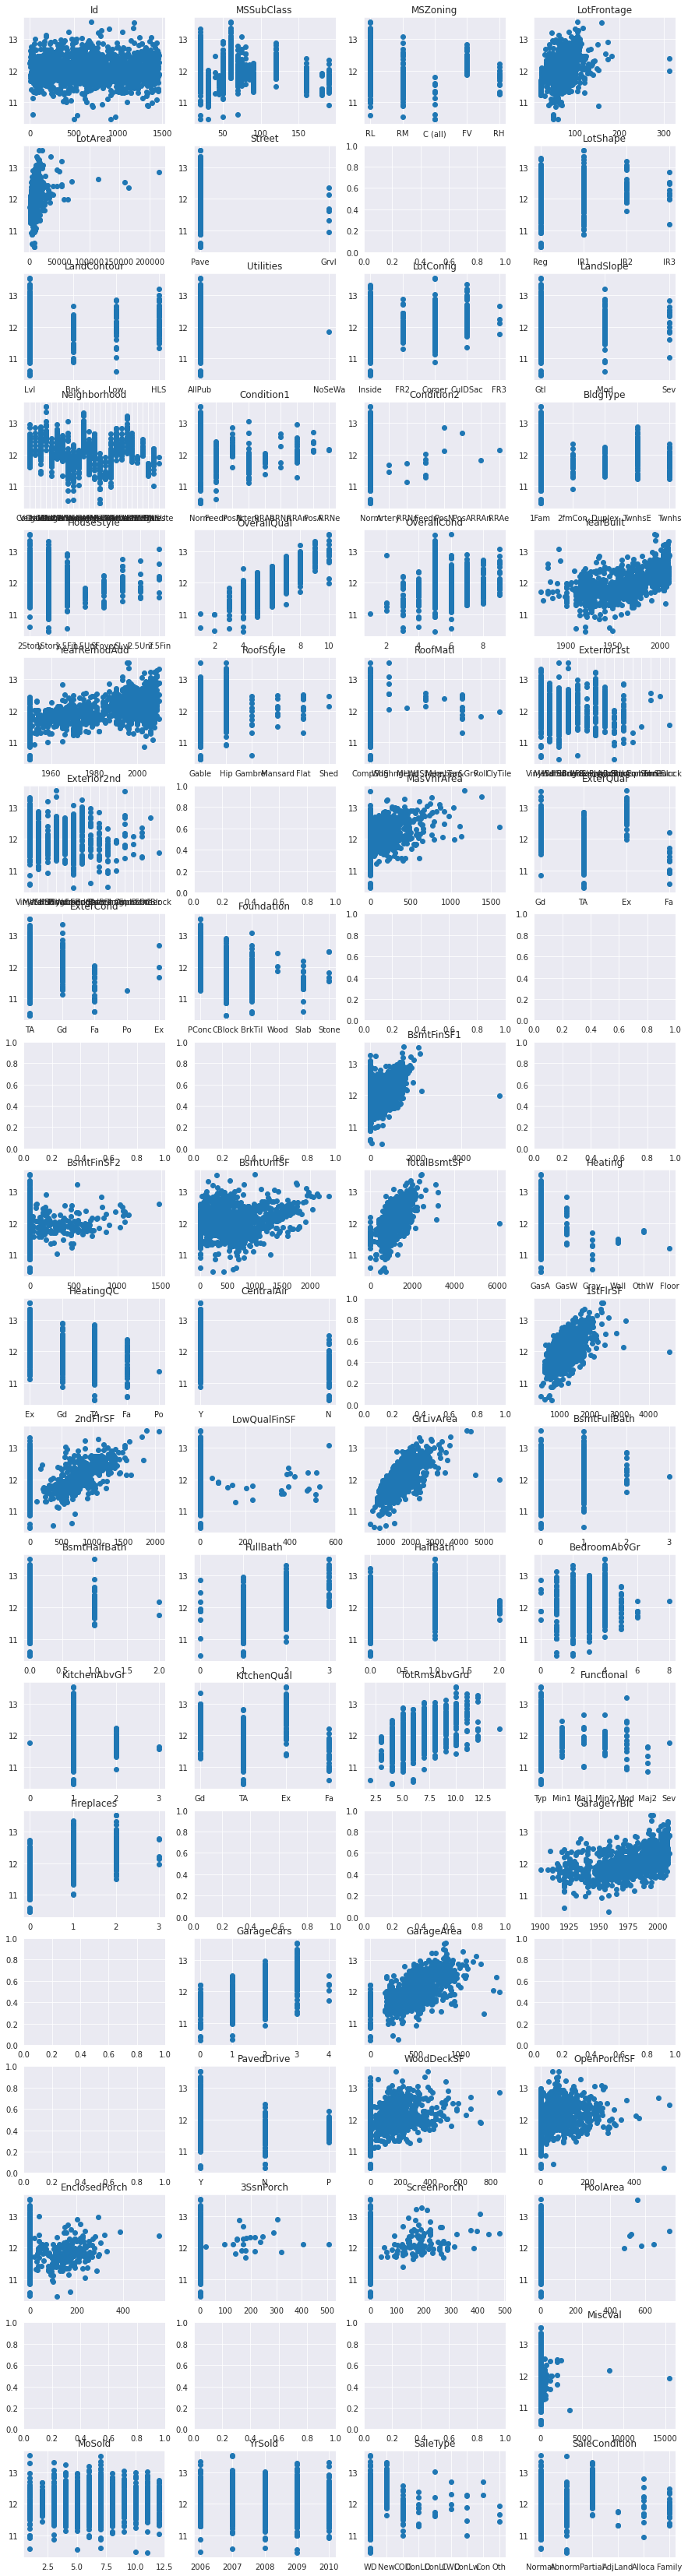

In [7]:
train.shape[1]
#a = int(np.sqrt(train.shape[1]))
a = 4
b = int(train.shape[1]/4)
r = int(train.shape[1]/a)
c = int(train.shape[1]/b)
i = 0
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(15, 60))
for row in ax:
    for col in row:
        #print(train.columns[i])
        #print(train[train.columns[i]].dtype)
        #col.plot()
        #ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
        try:
            #col.scatter(x = train[train.columns[i]], y = train['SalePrice'])
            col.scatter(x = train[train.columns[i]], y = np.log(train['SalePrice']))
            col.title.set_text(train.columns[i])
            #col.title(train.columns[i])
        except:
            temp=1
        #except Exception as e:
        #    print(e.message, e.args)
        finally:
            temp=1
        i = i + 1
        
plt.show()

More filtering of data to try

In [8]:
#Deleting outliers

#train = train.drop(train[(train['LotFrontage']>300) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['LotArea']>100000) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['BsmtFinSF1']>4000) & (train['SalePrice']<250000)].index)
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

train = train.drop(train[(train['OverallQual']>9) & (train['SalePrice']<220000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

Edit: Think this deletion is safe to do as there are only 2 points and they seem to be abnormal, possibly data error

Safe to drop the Id column now as we are finished deleting points (otherwise our Train_ID list will be smaller than y_train

In [9]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.000,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.000,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.000,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.000,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [10]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']


#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1458, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1458, 80) 
The test data size after dropping Id feature is : (1459, 79) 


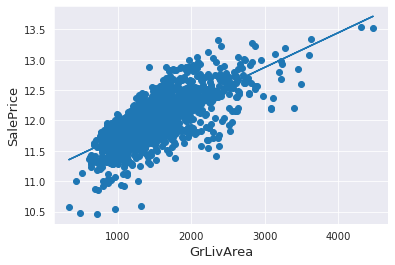

In [11]:
#Check the graphic again
fig, ax = plt.subplots()
#ax.scatter(train['GrLivArea'], train['SalePrice'])
ax.scatter(train['GrLivArea'], np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)
plt.show()

This chart does not look linear, or at least the line is not matching the data across the entire x axis. Looks like a drop off for High GrLivArea, seems home buyers are not willing to pay a corresponding amount extra for the large living area, looking for a "volume discount" maybe...
Lets look at this closer, first fit a line, next try a polynomial fit to compare

[5.70762509e-04 1.11618915e+01]


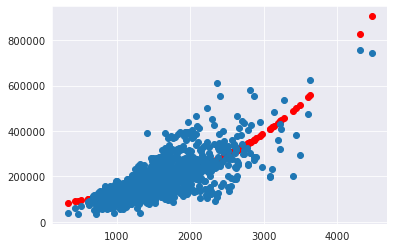

In [12]:
# linear 
x_data = train['GrLivArea']
y_data = train['SalePrice']
log_y_data = np.log(train['SalePrice'])

curve_fit = np.polyfit(x_data, log_y_data, 1)
print(curve_fit)
y = np.exp(1.11618915e+01) * np.exp(5.70762509e-04*x_data)
plt.plot(x_data, y_data, "o")
plt.scatter(x_data, y,c='red')

Need to look at the y_log relationship since that is what we will be predicting in the model (convert back later)

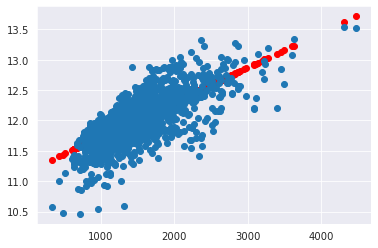

In [13]:
# linear with log y
y = np.exp(1.11618915e+01) * np.exp(5.70762509e-04*x_data)
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

Now we look at a polynomial fit

In [14]:
# polynomial
x_data = train['GrLivArea']
y_data = train['SalePrice']
log_y_data = np.log(train['SalePrice'])
curve_fit_gla = np.polyfit(x_data, y_data, 2)
y = curve_fit_gla[2] + curve_fit_gla[1]*x_data + curve_fit_gla[0]*x_data**2

plot the poly fit data

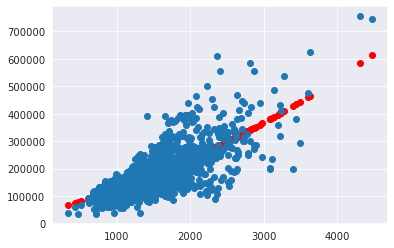

In [15]:
plt.plot(x_data, y_data, "o")
plt.scatter(x_data, y,c='red')

Now lets use a log y scale

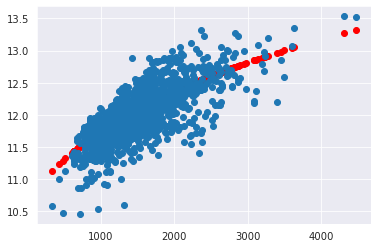

In [16]:
# polynomial with log y
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

In [17]:
y_data #HERE

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1458, dtype: int64

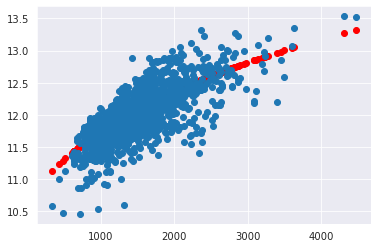

In [18]:
# polynomial with log y
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

This fit looks like it may be better, will add a column to the dataset using this equation after it is merged (all_data)

y = curve_fit_gla[2] + curve_fit_gla[1]*x_data + curve_fit_gla[0]*x_data**2

x_data = train['GrLivArea']


###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

Edit: todo - look for other outliers in all columns. Maybe better to use StandardScaler() and np.clip

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79, skew = 1.88 kurtosis = 6.50



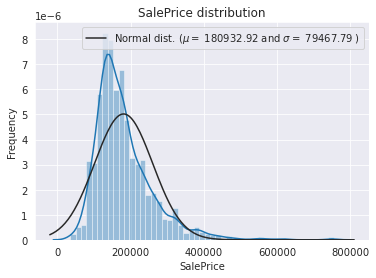

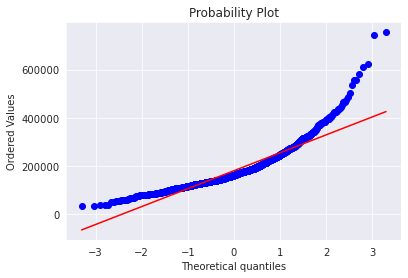

In [19]:
sns.distplot(train['SalePrice'] , fit=norm)

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


**Tansformation of the target variable**
 
Default is to use log1p as this is included in the evaluation metric, rmsle 
Edit: also trying box-cox transform.
The Box-Cox transform is given by:
<pre>
y = (x**lmbda - 1) / lmbda,  for lmbda > 0  
    log(x),                  for lmbda = 0
    
y = ((1+x)**lmbda - 1) / lmbda  if lmbda != 0
    log(1+x)                    if lmbda == 0

In [20]:
#We try the numpy function log1p which  applies log(1+x) to all elements of the column

# option 1 - original
#train["SalePrice"] = np.log1p(train["SalePrice"])

# Option 2: use box-cox transform - this performs worse than the log(1+x), reverting back...now it seems to be scoring better. Maybe my earlier evaluation was incorrect
# try different alpha values  between 0 and 1
lam_l = 0.35
train["SalePrice"] = boxcox1p(train["SalePrice"], lam_l) 

# Option 3: boxcox letting the algorithm select lmbda based on least-likelihood calculation
#train["SalePrice"], lam_l = boxcox1p(x=train["SalePrice"], lmbda=None)

# option 4 - compare to log1p => score is same
#train["SalePrice"] = np.log(train["SalePrice"])

Here is the difference between BoxCox and Log values, the difference is substantial at the value of a house

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


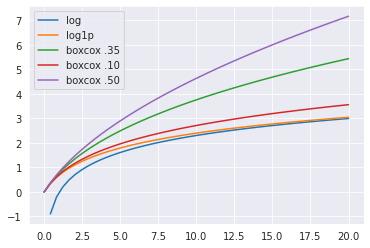

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


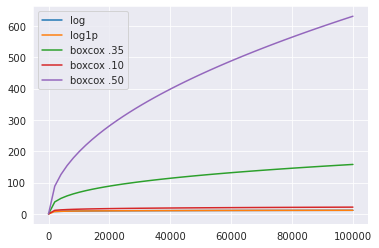

In [21]:
x = np.linspace(0, 20)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()

x = np.linspace(0, 100000)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()


 mu = 191.18 and sigma = 27.62, skew = 0.69 kurtosis = 1.31



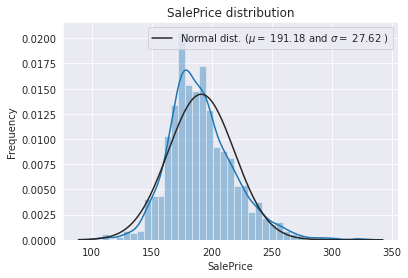

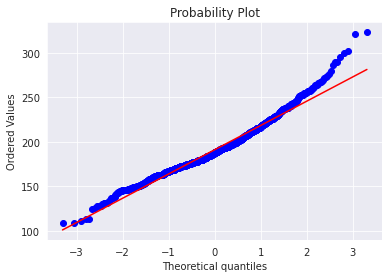

In [22]:
# to revert back use y = inv_boxcox1p(x, lam_l) => train["SalePrice"] = inv_boxcox1p(train["SalePrice"], lam_l)
# think the underlying formula is this: # pred_y = np.power((y_box * lambda_) + 1, 1 / lambda_) - 1


#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

Edit: Both distributions have a positive kurtosis, which means there is a steep dropoff in the curve from the center, or the tails have few points. Skewness is close to 0 now, so that metric is closer to a normal distribution. BoxCox1p() has worse numbers than log() but still performs better in the predictions, will keep BoxCox1p

##Features engineering

let's first  concatenate the train and test data in the same dataframe

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


Then, add this column from previous investigation to the dataset y = curve_fit_gla[2] + curve_fit_gla[1]x_data + curve_fit_gla[0]x_data**2

In [24]:
def add_gla(row, p):
    return (p[2] + p[1]*row.GrLivArea + p[0]*(row.GrLivArea**2))

#all_data['GrLivAreaPoly'] = all_data.apply(lambda row: add_gla(row,curve_fit_gla), axis=1)
#all_data[['GrLivAreaPoly','GrLivArea']].head()

* save this inv function for later, may need it:
<pre>
import cmath
d = (b**2) - (4*a*c)
print(-b-cmath.sqrt(d))/(2*a)
print(-b+cmath.sqrt(d))/(2*a)
def add_gla3(row, p):
    return (p[2] + p[1]*row.GrLivArea + p[0]*(row.GrLivArea**2)) <-- change this function
all_data['GrLivAreaPoly2'] = all_data.apply(lambda row: add_gla3(row,curve_fit_gla), axis=1)

* check and compare the new columns

Now for r squared calculations we need to limit the comparison to only the train data since the test data does not have a Sales Price to compare to

In [25]:
all_data.GrLivArea[:ntrain]

0       1710
1       1262
2       1786
3       1717
4       2198
        ... 
1453    1647
1454    2073
1455    2340
1456    1078
1457    1256
Name: GrLivArea, Length: 1458, dtype: int64

Compare the r-squared values

In [26]:
correlation_matrix = np.corrcoef(all_data.GrLivArea[:ntrain], y_train)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.5445354638265302


In [27]:
a='''
correlation_matrix = np.corrcoef(all_data.GrLivAreaPoly[:ntrain], y_train)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)'''

My equation has a worse correlation... will need to investigate this later. For now, i will simplify an just use a direct function...

Compare the r-squared values for different functions

In [28]:
for i in range(1,11,1):
    j = i/10
    correlation_matrix = np.corrcoef(all_data.GrLivArea[:ntrain]**j, y_train)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    print(j, r_squared)

0.1 0.5429614947322927
0.2 0.5453735215818089
0.3 0.5472321377037026
0.4 0.5485354482960584
0.5 0.5492808172916986
0.6 0.5494651982899944
0.7 0.5490854594527175
0.8 0.5481386989774741
0.9 0.5466225486788447
1.0 0.5445354638265302


use the 0.3 value as the improvement below this value is minimal

In [29]:
def add_gla2(row, p):
    return (row.GrLivArea**p)

#all_data['GrLivAreaRoot'] = all_data.apply(lambda row: add_gla2(row,0.3), axis=1)

In [30]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


###Missing Data

In [31]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


separate into lists for each data type

In [32]:
all_numerical = all_data.select_dtypes(include=np.number).columns.tolist()
missing_data.index.values.tolist()
missing_df = all_data[missing_data.index.values.tolist()]
missing_numerical = missing_df.select_dtypes(include=np.number).columns.tolist()

Text(0.5, 1.0, 'Percent missing data by feature')

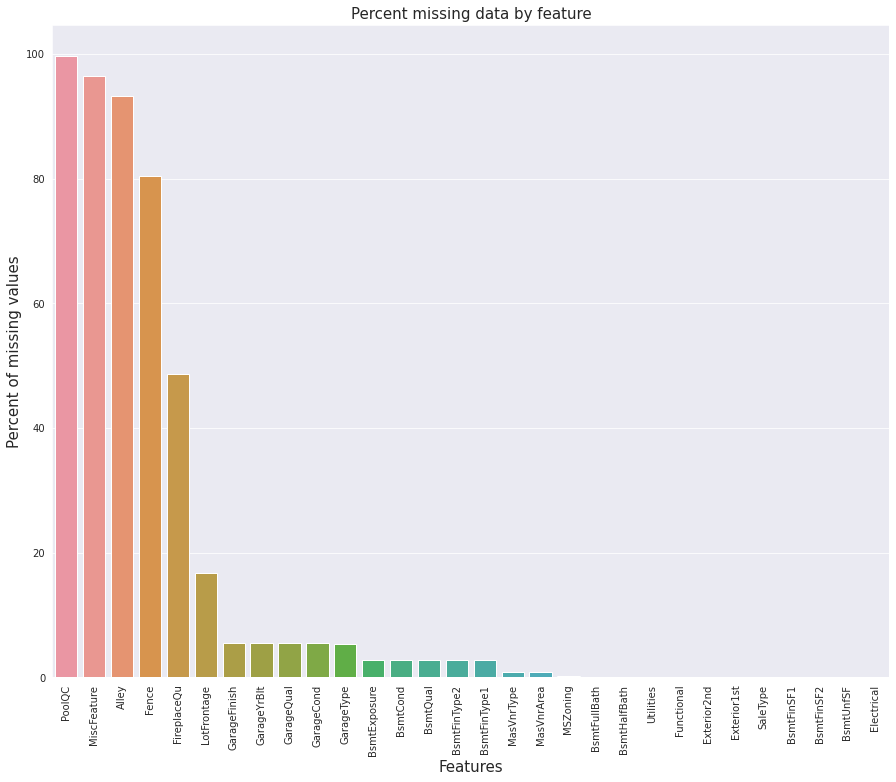

In [33]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


Cross Correlation chart to view collinearity within the features. Kendall's seems appropriate as the Output Variable is numerical and much of the input is categorical. Here is a chart to guide you to which method to use based on your dataset.

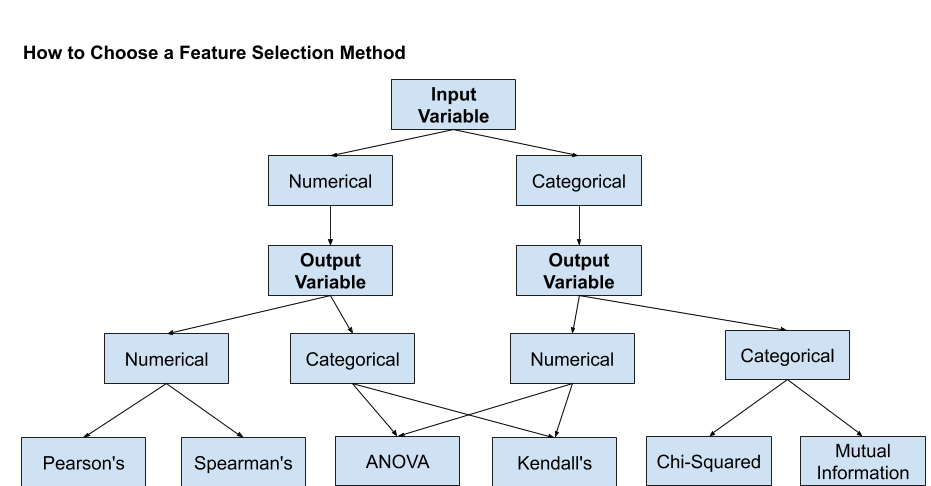

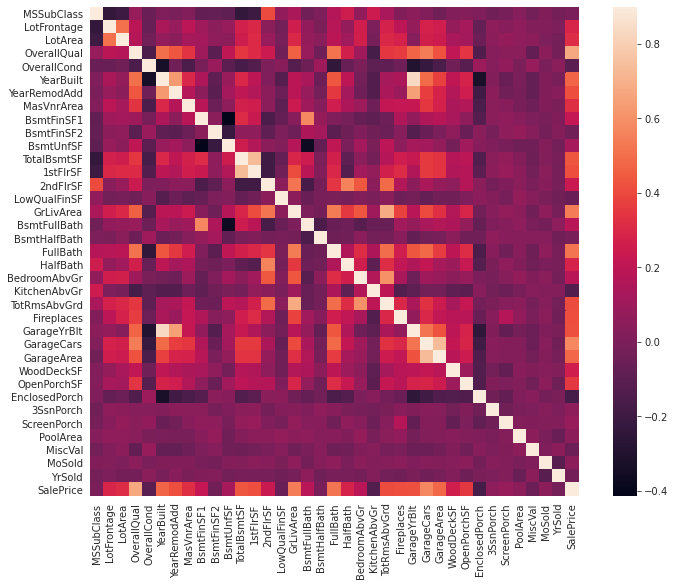

In [34]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Look at some correlation values in a list format

In [35]:
print (corrmat['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corrmat['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice     1.000
OverallQual   0.671
GarageCars    0.573
GrLivArea     0.545
FullBath      0.519
Name: SalePrice, dtype: float64 

MiscVal         -0.051
LowQualFinSF    -0.055
OverallCond     -0.103
KitchenAbvGr    -0.135
EnclosedPorch   -0.172
Name: SalePrice, dtype: float64


In [36]:
all_data.shape

(2917, 79)

###Imputing missing values 

Some imputation methods result in biased parameter estimates, such as means, correlations, and regression coefficients, unless the data are Missing Completely at Random (MCAR). The bias is often worse than with listwise deletion, the default in most software.  

The extent of the bias depends on many factors, including the imputation method, the missing data mechanism, the proportion of the data that is missing, and the information available in the data set.  

Moreover, all single imputation methods underestimate standard errors.

Reference: https://www.theanalysisfactor.com/mar-and-mcar-missing-data/

Multiple imputation can overcome most of these shortcomings, but at the expense of time. They take more time to implement and run

Reference: https://www.theanalysisfactor.com/missing-data-two-recommended-solutions/

Methods: (can use in pipeline - estimator = make_pipeline(imputer, regressor) ) reference: https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py  

Simple Regression:

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean') for numerical
imp = SimpleImputer(strategy="most_frequent") for categorical

Multivariate Regression:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

kNN:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")

Other:
Stochastic regression, Bayesian Linear Regression, Bayesian Binary Logistic Regression
https://pypi.org/project/autoimpute/

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 
- **MiscFeature** : data description says NA means "no misc feature"
- **Alley** : data description says NA means "no alley access"
- **Fence** : data description says NA means "no fence"
- **FireplaceQu** : data description says NA means "no fireplace"
- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.

In [37]:
ImputeToNone = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for col in ImputeToNone:  
    all_data[col].fillna("None", inplace=True)

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [38]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
#all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
#    lambda x: x.fillna(x.median()))

try another method, imputation

In [39]:
# selecting another column
all_data[missing_numerical]

,LotFrontage,GarageYrBlt,MasVnrArea,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
0,65.000,2003.000,196.000,1.000,0.000,706.000,0.000,150.000
1,80.000,1976.000,0.000,0.000,1.000,978.000,0.000,284.000
2,68.000,2001.000,162.000,1.000,0.000,486.000,0.000,434.000
3,60.000,1998.000,0.000,1.000,0.000,216.000,0.000,540.000
4,84.000,2000.000,350.000,1.000,0.000,655.000,0.000,490.000
...,...,...,...,...,...,...,...,...
2912,21.000,nan,0.000,0.000,0.000,0.000,0.000,546.000
2913,21.000,1970.000,0.000,0.000,0.000,252.000,0.000,294.000
2914,160.000,1960.000,0.000,1.000,0.000,1224.000,0.000,0.000
2915,62.000,nan,0.000,0.000,1.000,337.000,0.000,575.000


Look for any good correlations to use for imputation

In [40]:
corrmat_all = all_data[all_numerical].corr(method='kendall')
corrmat_all

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000,-0.272,-0.235,0.076,-0.051,0.007,0.002,-0.006,-0.076,-0.084,...,-0.037,0.014,0.021,-0.002,-0.029,-0.033,-0.003,-0.027,0.010,-0.015
LotFrontage,-0.272,1.000,0.512,0.173,-0.083,0.139,0.096,0.210,0.116,0.039,...,0.263,0.088,0.128,-0.074,0.008,0.069,0.063,0.031,0.010,0.003
LotArea,-0.235,0.512,1.000,0.150,-0.062,0.086,0.071,0.151,0.122,0.049,...,0.252,0.131,0.125,-0.034,0.023,0.073,0.063,0.060,0.004,-0.017
OverallQual,0.076,0.173,0.150,1.000,-0.162,0.518,0.455,0.352,0.135,-0.083,...,0.430,0.231,0.347,-0.163,0.018,0.025,0.023,-0.067,0.021,-0.012
OverallCond,-0.051,-0.083,-0.062,-0.162,1.000,-0.336,-0.058,-0.154,-0.019,0.087,...,-0.170,-0.029,-0.143,0.119,0.041,0.045,-0.017,0.056,-0.004,0.032
YearBuilt,0.007,0.139,0.086,0.518,-0.336,1.000,0.650,0.299,0.168,-0.077,...,0.385,0.209,0.290,-0.344,0.009,-0.053,-0.004,-0.064,0.011,-0.005
YearRemodAdd,0.002,0.096,0.071,0.455,-0.058,0.650,1.000,0.187,0.068,-0.094,...,0.292,0.179,0.269,-0.214,0.041,-0.048,-0.017,-0.048,0.011,0.032
MasVnrArea,-0.006,0.210,0.151,0.352,-0.154,0.299,0.187,1.000,0.212,-0.025,...,0.281,0.153,0.177,-0.164,0.023,0.051,-0.008,-0.036,0.010,-0.007
BsmtFinSF1,-0.076,0.116,0.122,0.135,-0.019,0.168,0.068,0.212,1.000,0.041,...,0.180,0.154,0.066,-0.119,0.052,0.078,0.019,0.018,-0.005,0.020
BsmtFinSF2,-0.084,0.039,0.049,-0.083,0.087,-0.077,-0.094,-0.025,0.041,1.000,...,-0.010,0.052,-0.049,0.027,0.001,0.057,0.058,0.035,-0.010,0.022


Look for other correlations, maybe all the basement olumns will correlate like BsmtFullBath and BsmtFinSF1 and Fin vs Unf have negative correlation. Both make sense...

In [41]:
corrmat2 = all_data[missing_numerical].corr(method='kendall')
corrmat2
#print (corrmat2['LotFrontage'].sort_values(ascending=False), '\n')

,LotFrontage,GarageYrBlt,MasVnrArea,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
LotFrontage,1.000,0.090,0.210,0.088,-0.025,0.116,0.039,0.061
GarageYrBlt,0.090,1.000,0.235,0.105,-0.067,0.093,-0.113,0.117
MasVnrArea,0.210,0.235,1.000,0.144,0.030,0.212,-0.025,0.040
BsmtFullBath,0.088,0.105,0.144,1.000,-0.153,0.565,0.158,-0.344
BsmtHalfBath,-0.025,-0.067,0.030,-0.153,1.000,0.079,0.130,-0.086
BsmtFinSF1,0.116,0.093,0.212,0.565,0.079,1.000,0.041,-0.390
BsmtFinSF2,0.039,-0.113,-0.025,0.158,0.130,0.041,1.000,-0.238
BsmtUnfSF,0.061,0.117,0.040,-0.344,-0.086,-0.390,-0.238,1.000


looks like we have 2, MasVnrArea and BsmtFinSF1 so use those for this test

In [42]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.000,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
2913,160,RM,21.000,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2914,20,RL,160.000,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2915,85,RL,62.000,10441,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


In [43]:
def ImputeData(all_data, numerical_input, col_to_impute):
    from sklearn.impute import KNNImputer
    
    Missing = all_data[numerical_input]
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    imputer.fit(Missing)
    Xtrans = imputer.transform(Missing)
    df_miss = pd.DataFrame(Xtrans,columns = Missing.columns)
    all_data[col_to_impute] = df_miss[col_to_impute]
    return (all_data)
    

In [44]:
all_data = ImputeData(all_data, all_numerical, 'LotFrontage')

In [45]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.000,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
2913,160,RM,21.000,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2914,20,RL,160.000,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2915,85,RL,62.000,10441,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement


In [46]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [47]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [48]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Alternate Method to calculate missing Zoning values, neighborhood should be zoned the same most of the time

In [49]:
# this one may be a bit dangerous, maybe try to get zone from neighborhood most common value, similar to LotFrontage previously
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# NEW, slightly worse score
#all_data["MSZoning"] = all_data.groupby("Neighborhood")["MSZoning"].transform(
#    lambda x: x.fillna(x.mode()))

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [50]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [51]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [52]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [53]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [54]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [55]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [56]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [57]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [58]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


No missing values


**Transforming some numerical variables that are really categorical**

Edit: I will add a new column year and date as ordinal, since there is some order to the values it may be useful

In [59]:
all_data['MSSubClass'].value_counts()


20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [60]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [61]:
all_data.shape

(2917, 78)

Want to add ordinal or int column for Year and Month, this is the function to perform that task

In [62]:
import datetime
Yr = all_data['YrSold'].min()
Mo = all_data['MoSold'].min()
t = datetime.datetime(Yr, Mo, 1, 0, 0)

def calculateYrMo (row):   
    return int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds())

In [63]:
# either way will work
#all_data['YrMoSold'] = all_data.apply(lambda row: int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds()), axis=1)

all_data['YrMoSold'] = all_data.apply(lambda row: calculateYrMo(row), axis=1)

In [64]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


**Label Encoding some categorical variables that may contain information in their ordering set** 

**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [65]:
from sklearn.preprocessing import LabelEncoder
#cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#        'YrSold', 'MoSold', 'YrMoSold')

# Edit: Dropping PoolQC for missing values => makes the model worse, reverting
#all_data = all_data.drop(['PoolQC'], axis=1)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'YrMoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2917, 79)


In [66]:
#all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [67]:
# feature engineering add new features 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd'] # A-
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']) # B-
#all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])) # C-
#all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF']) # D-
#all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0) # E-
#all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # F-
#all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # G-
#all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # H-
#all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # I-


**Skewed features**

In [68]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [69]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam_f)
    
    #all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 62 skewed numerical features to Box Cox transform


I recommend plotting the cumulative sum of eigenvalues (assuming they are in descending order). If you divide each value by the total sum of eigenvalues prior to plotting, then your plot will show the fraction of total variance retained vs. number of eigenvalues. The plot will then provide a good indication of when you hit the point of diminishing returns (i.e., little variance is gained by retaining additional eigenvalues).

**Getting dummy categorical features**

In [70]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 223)


Try dropping the lowest correlating columns

In [71]:
correlations = corrmat['SalePrice'].sort_values(ascending=False)
df_corr = correlations.to_frame()
print(df_corr.query("abs(SalePrice) < 0.011"))
low_corr = df_corr.query("abs(SalePrice) < 0.011").index.values.tolist()
#print('dropping these columns for low correlation', low_corr)
#for i in low_corr: 
#    all_data = all_data.drop([i], axis=1)

              SalePrice
MSSubClass       -0.004
BsmtHalfBath     -0.010


Dropping even a single column gives a worse score
Conclusion: there is information in every column and the models are able to extract that information effectively!

Do some PCA for the dataset, to remove some of the collinearity. Not sure if this will have any effect as collinearity is usually not detrimental to many or most algorithms

Text(0, 0.5, 'cumulative explained variance')

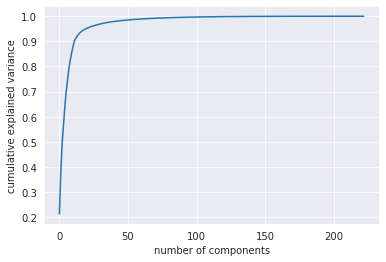

In [72]:
# to choose number of components, look at this chart. Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
from sklearn.decomposition import PCA

pca = PCA().fit(all_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

 We choose number of eigenvalues to calculate based on previous chart, 20 looks like a good number, the chart starts to roll off around 15 and almost hits max a 20. We can also try 30,40 and 50 to squeeze a little more variance out...

In [73]:
#do PCA/StandardScaler+clip here or before the skew boxcox1p transform

n_components = 50
pca = PCA(n_components=n_components)
all_data_pca = pca.fit_transform(all_data)

our column count went from 216 to n_component value

In [74]:
print(all_data.shape)
print(all_data_pca.shape)

(2917, 223)
(2917, 50)


Edit: pca.components_ is the matrix you can use to calculate the inverse of the PCA analysis, i.e. go back to the original dataset
reference: https://stats.stackexchange.com/a/143949

In [75]:
weights = np.round(pca.components_, 3) 
ev = np.round(pca.explained_variance_ratio_, 3)
print('explained variance ratio',ev)
pca_wt = pd.DataFrame(weights)#, columns=all_data.columns)
pca_wt.head()

explained variance ratio [0.213 0.167 0.114 0.076 0.073 0.061 0.048 0.044 0.033 0.028 0.025 0.022
 0.01  0.009 0.007 0.006 0.005 0.004 0.003 0.003 0.003 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001]


,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,0.046,-0.015,-0.047,-0.000,-0.004,0.016,-0.003,-0.004,0.000,-0.002,...,0.000,0.000,-0.000,-0.000,0.001,0.001,-0.000,0.000,-0.001,0.000
1,-0.026,-0.017,-0.062,-0.000,-0.002,0.028,-0.001,-0.028,0.001,-0.003,...,0.000,-0.005,0.001,0.001,0.004,0.001,0.001,0.000,-0.001,-0.005
2,-0.035,0.024,0.058,0.000,0.002,-0.016,-0.003,0.021,-0.008,0.003,...,-0.001,0.017,-0.000,-0.016,-0.003,-0.001,-0.001,0.000,-0.012,0.017
3,0.008,0.004,0.044,-0.000,-0.001,-0.013,0.003,-0.003,0.006,0.000,...,0.000,-0.002,-0.000,0.004,-0.003,-0.001,0.000,0.001,0.006,-0.003
4,-0.004,-0.011,-0.038,-0.000,-0.001,-0.004,-0.000,0.000,-0.007,0.001,...,-0.000,0.002,0.001,0.001,0.003,0.001,0.000,-0.001,-0.005,0.001


The shape values are the number of columns in the PCA x the number of original columns

In [76]:
pca_wt.shape 

(50, 223)

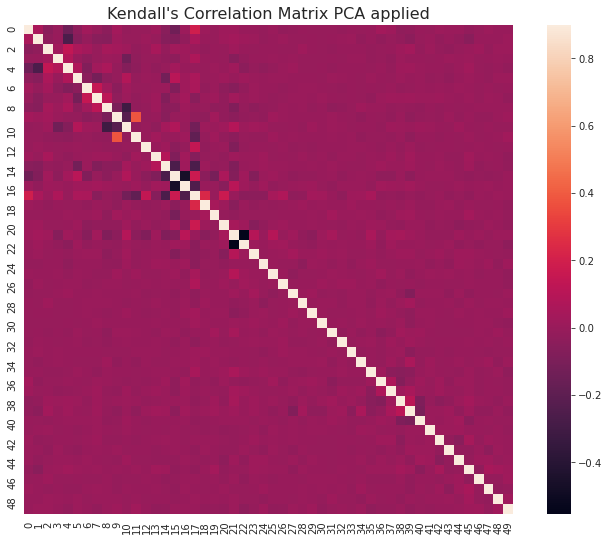

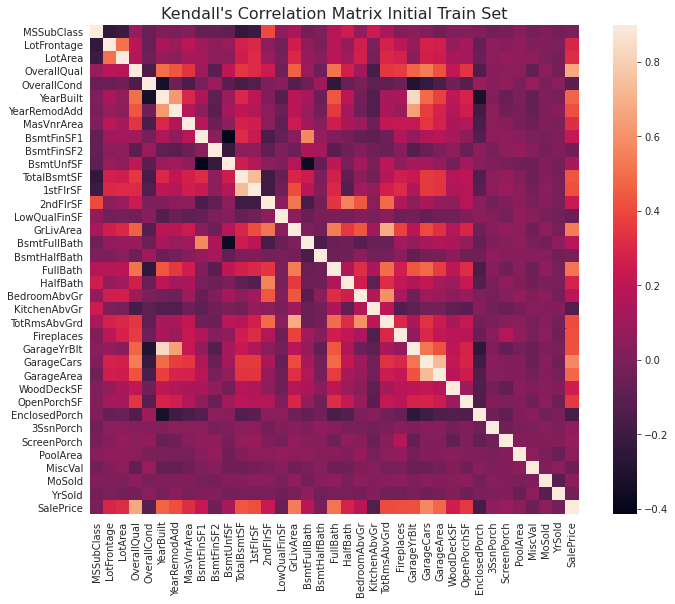

In [77]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = pd.DataFrame(all_data_pca).corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix PCA applied", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True)


#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True);


As you can see, the PCA analysis did its job, the features show little correlation now

Another look at the feature to output correlations

In [78]:
train_orig = train.copy()
train_orig['SalePrice'] = y_train
corrmat = train_orig.corr(method='kendall')
print (corrmat['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corrmat['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice     1.000
OverallQual   0.671
GarageCars    0.573
GrLivArea     0.545
FullBath      0.519
Name: SalePrice, dtype: float64 

MiscVal         -0.051
LowQualFinSF    -0.055
OverallCond     -0.103
KitchenAbvGr    -0.135
EnclosedPorch   -0.172
Name: SalePrice, dtype: float64


In [79]:
a=''' not working now
correlations = corrmat["SalePrice"].sort_values(ascending=False)
features = correlations.index[0:10]

sns.pairplot(train[features], size = 2.5)
plt.show();'''

Getting the new train and test sets. 

In [80]:
print(type(all_data))
print(type(pd.DataFrame(all_data_pca)))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Testing the new PCA dataset for analysis - RMSE looks works after PCA is applied, need to look at the Kaggle score later and see if it correlates, could be a mistake to use PCA on categorical dummy data. However, XGB is better with PCA n=50 option. Maybe use a heavier weight for that portion, or use all_data_pca only on that model...

In [81]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
rc = RobustScaler()

use_pca = 0 # using PCA currently hurts the score
use_normalization = 0 # using StandardScaler doesn't work, try RobustScaler now

if (use_pca == 1):
    all_data_pca = pd.DataFrame(all_data_pca)
    train = all_data_pca[:ntrain]
    test = all_data_pca[ntrain:]
    all_data_pca.head()
elif (use_normalization == 1):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = sc.fit_transform(train.values)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = sc.transform(test.values)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)   
elif (use_normalization == 2):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = rc.fit_transform(train.values)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = rc.transform(test.values)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)  
else:
    # back to original splits (from train.csv and test.csv)
    train = all_data[:ntrain]
    test = all_data[ntrain:]


Save Cleansed Data to disk

In [82]:
save_data = 0
if (save_data == 1):
    df1 = train.copy()
    df1['SalePrice'] = inv_boxcox1p(y_train, lam_l)
    df1.insert(0, 'Id', list(train_ID), allow_duplicates=False)
    df1.to_csv('HousePricesTrain.csv', index=False)  
    df2 = test.copy()
    df2.insert(0, 'Id', list(test_ID), allow_duplicates=False)
    df2.to_csv('HousePricesTest.csv', index=False) 

Compare Train to Test data, verify the distributions look similar, maybe add probablity plots per feature with train and test on same chart

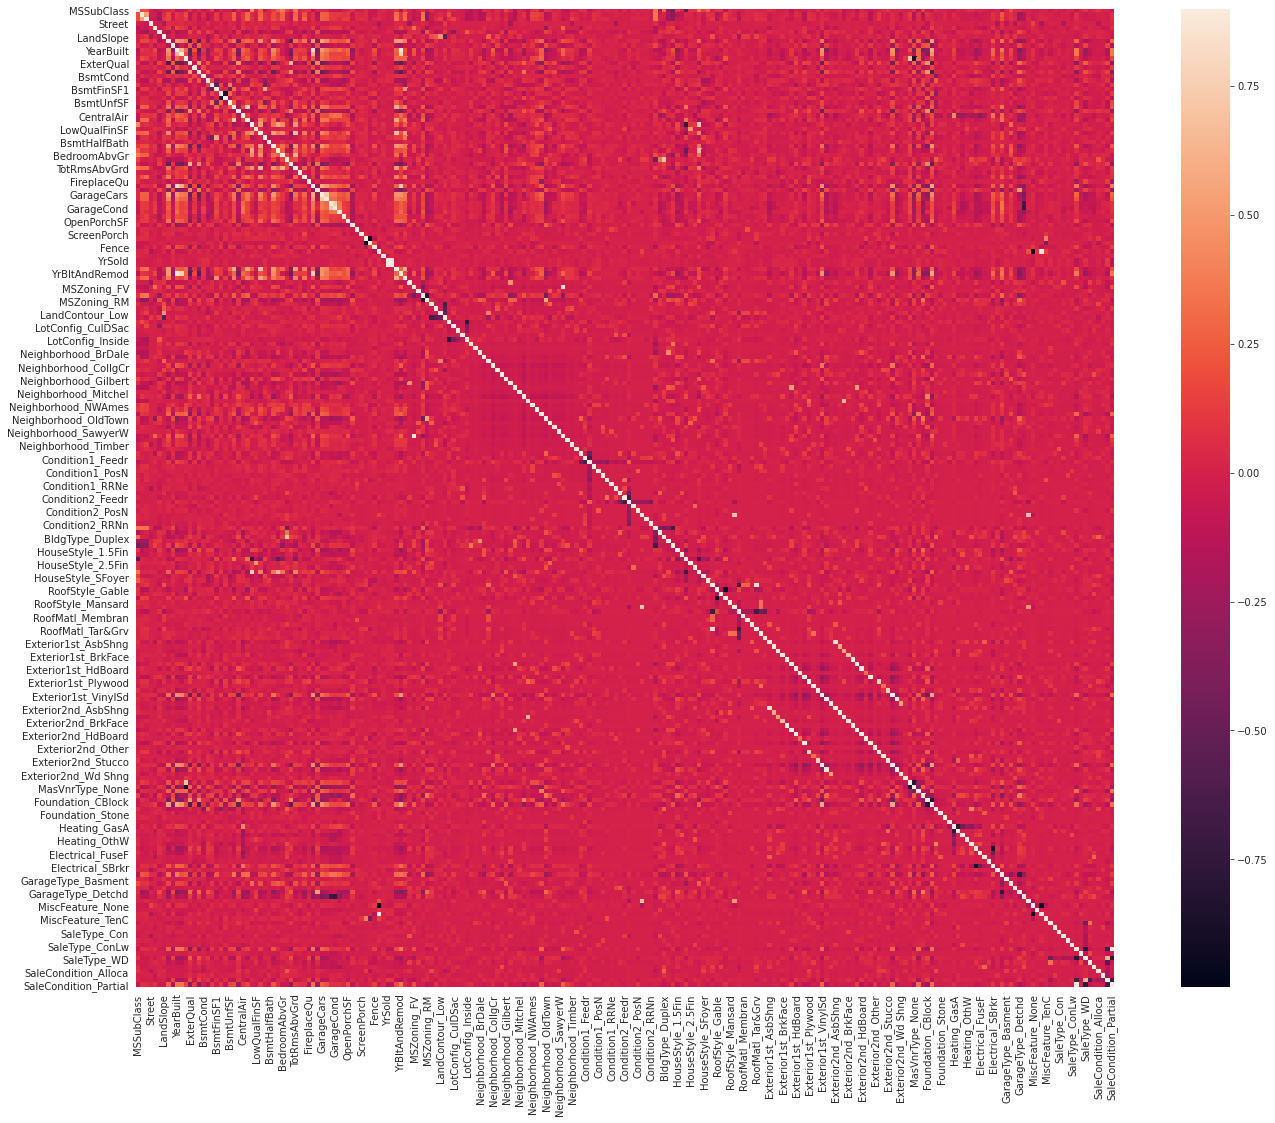

In [83]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat, vmax=0.9, square=True)

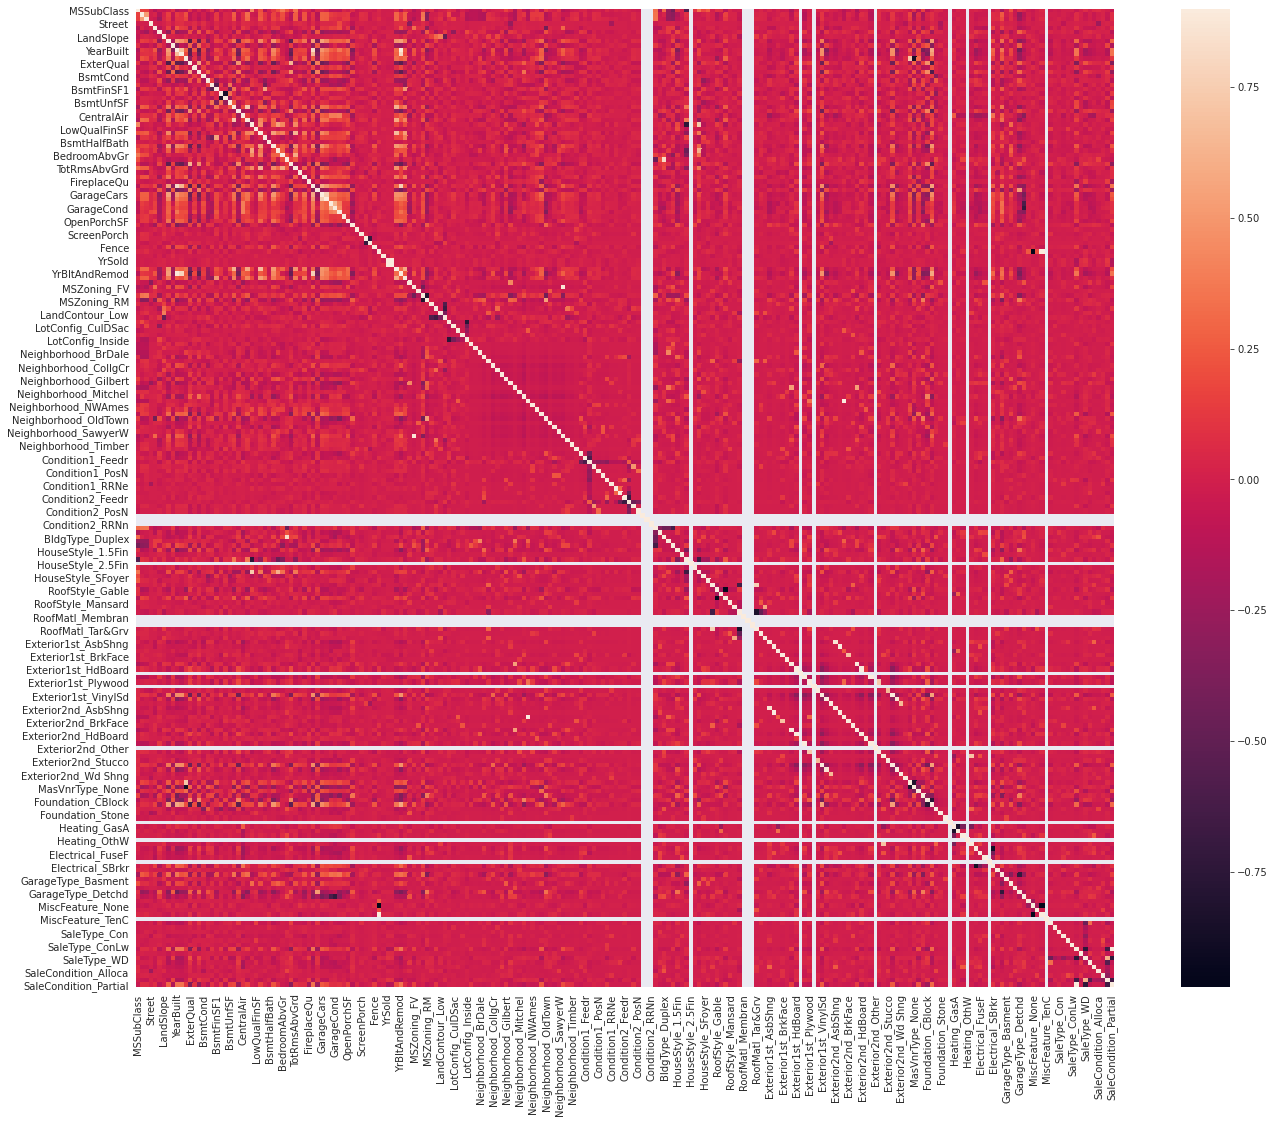

In [84]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = test.corr(method='kendall')
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat, vmax=0.9, square=True)

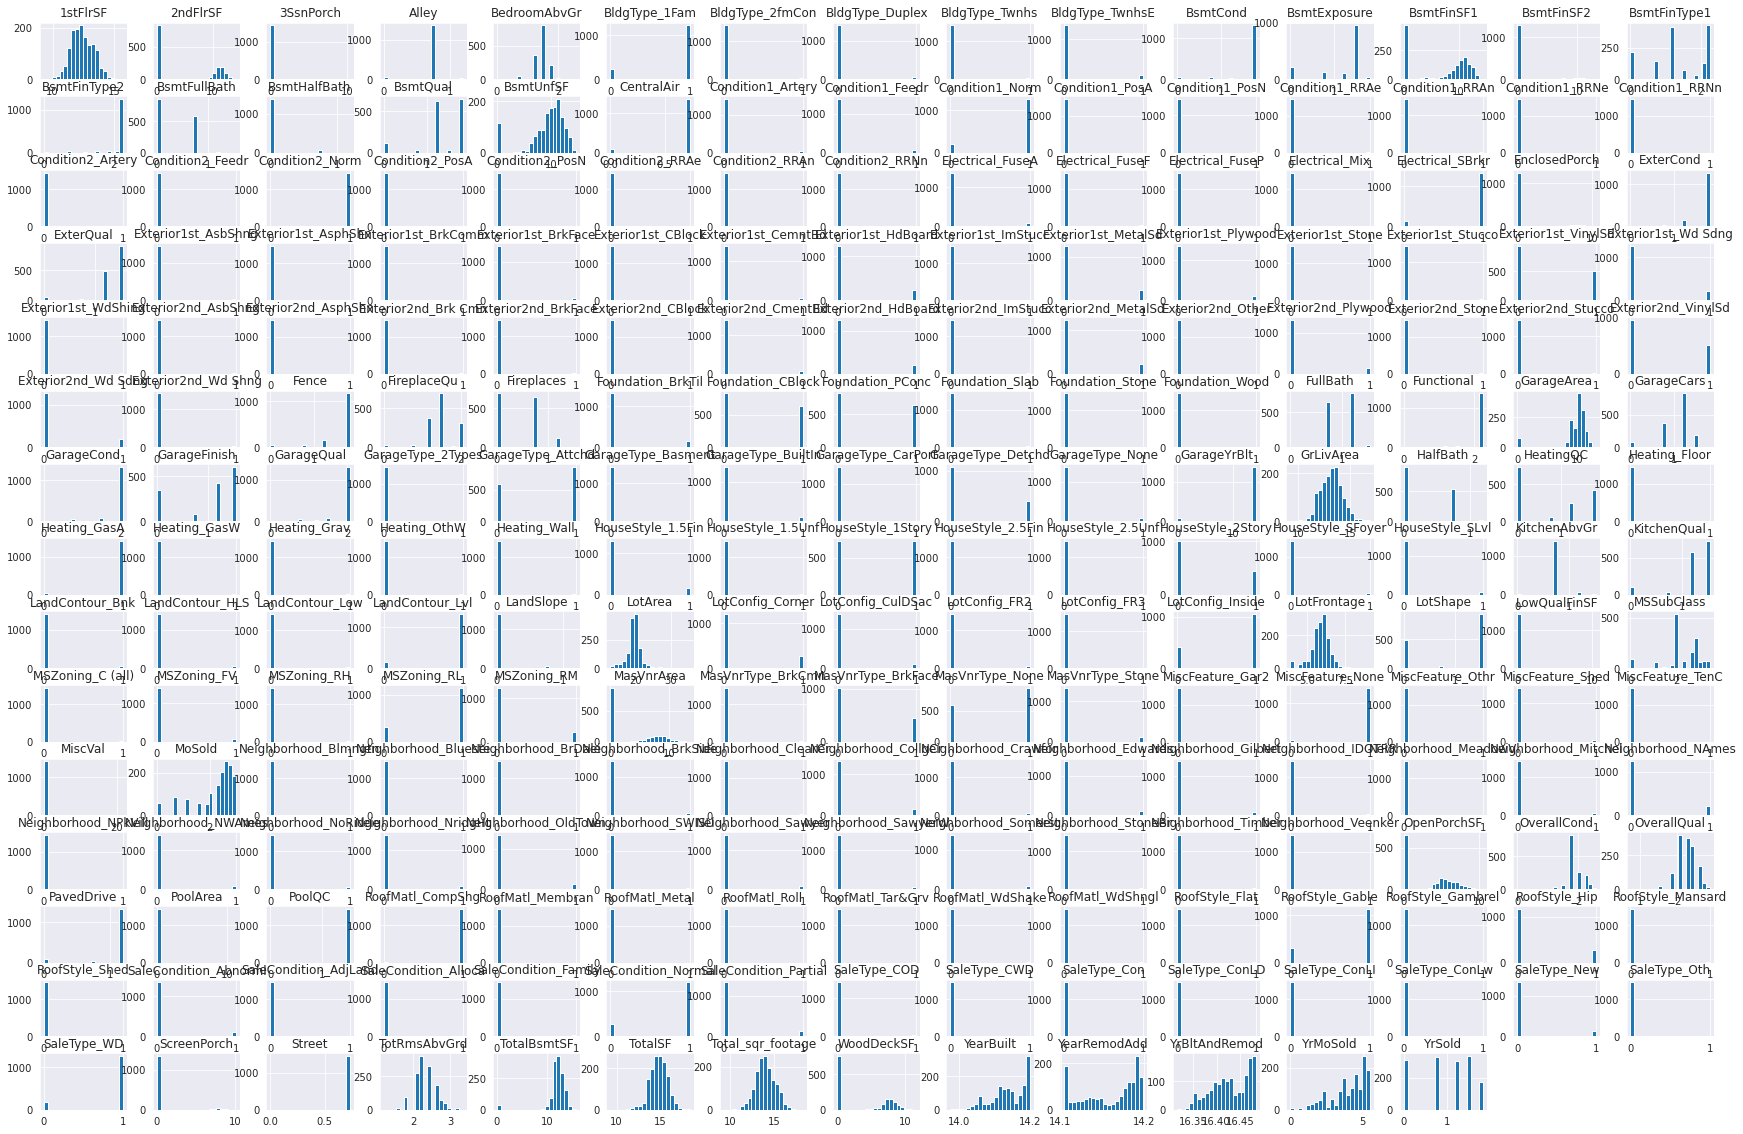

In [85]:
train.hist(bins=20, figsize=(30,20))
plt.show()

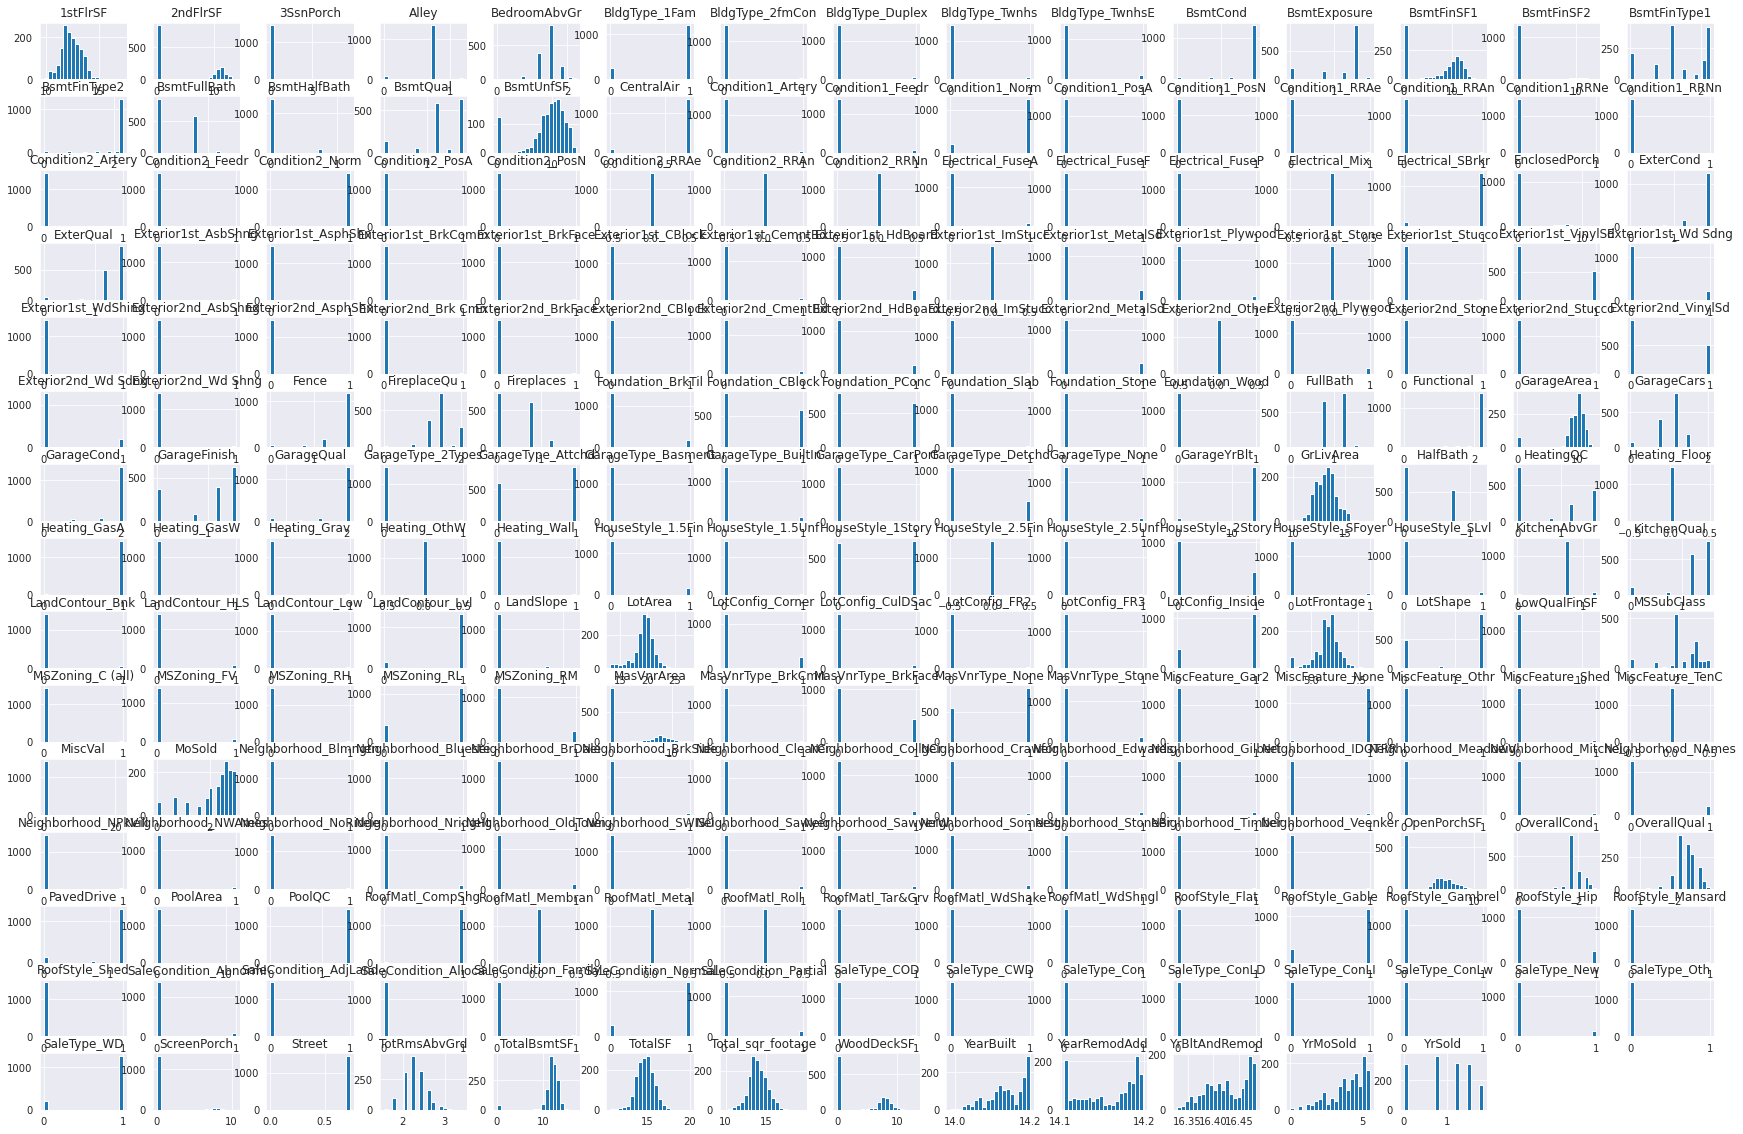

In [86]:
test.hist(bins=20, figsize=(30,20))
plt.show()

In [87]:
train.describe()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,...,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000
mean,2.305,5.898,19.549,0.727,0.718,1.006,0.043,2.255,1.939,14.137,...,0.003,0.082,0.002,0.869,0.069,0.003,0.008,0.014,0.822,0.084
std,0.784,0.617,2.027,0.047,0.156,0.721,0.186,0.267,0.259,0.048,...,0.058,0.275,0.045,0.338,0.254,0.052,0.090,0.116,0.383,0.278
min,0.000,3.933,12.879,0.000,0.000,0.000,0.000,0.730,0.000,13.977,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.056,5.685,18.776,0.730,0.730,0.000,0.000,2.056,1.820,14.110,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
50%,2.260,5.969,19.660,0.730,0.730,1.541,0.000,2.260,1.820,14.140,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,2.886,6.225,20.472,0.730,0.730,1.541,0.000,2.440,2.056,14.183,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
max,3.438,9.126,35.391,0.730,1.194,1.541,1.194,2.886,2.603,14.198,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [88]:
test.describe()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,...,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000
mean,2.290,5.867,19.428,0.727,0.707,1.009,0.032,2.250,1.931,14.137,...,0.002,0.080,0.003,0.863,0.061,0.005,0.008,0.018,0.825,0.082
std,0.807,0.629,1.907,0.047,0.175,0.722,0.154,0.281,0.277,0.048,...,0.045,0.272,0.052,0.344,0.239,0.074,0.090,0.132,0.380,0.275
min,0.000,3.933,13.242,0.000,0.000,0.000,0.000,0.730,0.000,13.989,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.056,5.685,18.698,0.730,0.730,0.000,0.000,2.056,1.820,14.109,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
50%,2.056,5.942,19.629,0.730,0.730,1.541,0.000,2.260,1.820,14.140,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,2.886,6.221,20.443,0.730,0.730,1.541,0.000,2.440,2.056,14.184,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
max,3.438,8.104,27.755,0.730,1.194,1.541,1.194,2.886,2.603,14.198,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


split train into train and validate 1458 records -> 70/30 => 1000 Train/400 Val

In [89]:
a='''
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X = train
y = y_train
train, val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=201)#, stratify=y)'''

In [90]:
print("Modelling: ", datetime.datetime.now())

Modelling:  2020-07-21 09:47:07.706943


#Modelling

**Import libraries**

In [91]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

#from sklearn.metrics import mean_squared_log_error
# to run locally: conda install -c anaconda py-xgboost
import xgboost as xgb
import lightgbm as lgb


**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has no shuffle attribute, so we add one line of code,  in order to shuffle the dataset  prior to cross-validation

replace cross_val_score() with cross_validate()
# reference: https://scikit-learn.org/stable/modules/cross_validation.html

    from sklearn.metrics import make_scorer
    scoring = {'prec_macro': 'precision_macro',
               'rec_macro': make_scorer(recall_score, average='macro')}
    scores = cross_validate(clf, X, y, scoring=scoring,
                            cv=5, return_train_score=True)
    sorted(scores.keys())
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
     'train_prec_macro', 'train_rec_macro']
    scores['train_rec_macro']
    array([0.97..., 0.97..., 0.99..., 0.98..., 0.98...])

Kfold is useful for thorough testing of a model, will give a more accurate score based on remove some data test on the remaining and change the data removed each time. See image below for details:

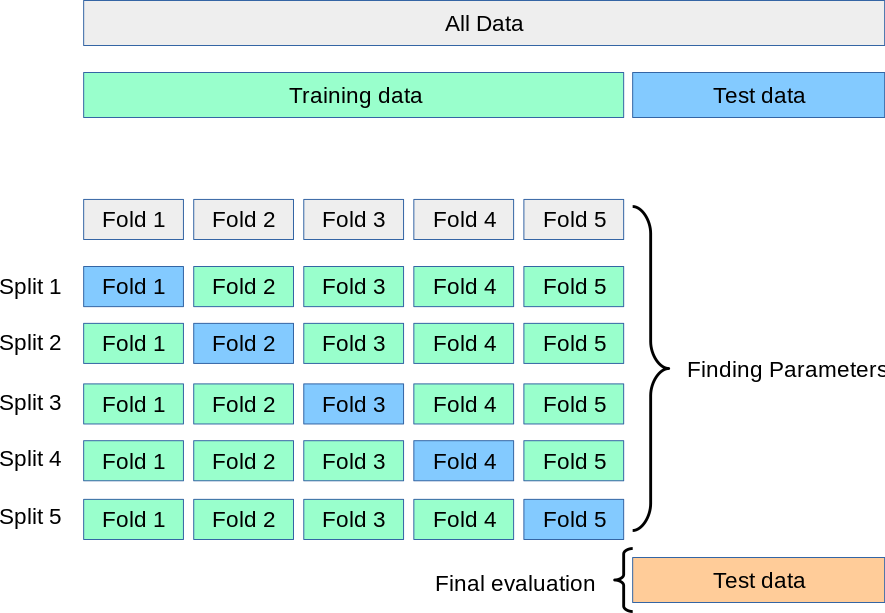

In [92]:
#Validation function
# train.values and y_train are both log scaled so just need to take the square of the delta between them to calculate the error, then take the sqrt to get rmsle
# but for now y_train is boxcox1p(), not log(). Use this to convert back: inv_boxcox1p(y_train, lam_l)
n_folds=5 # was 5 => better score but twice as slow now

def rmsle_cv(model):
    print("running rmsle_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf)) # also r2
    print("raw rmse scores for each fold:", rmse)
    return(rmse)

def r2_cv(model):
    print("running r2_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    r2= cross_val_score(model, train.values, y_train, scoring="r2", cv = kf) # also r2
    print("raw r2 scores for each fold:", r2)
    return(r2)

# used for another competition
def mae_cv(model):
    print("running mae_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    mae = -cross_val_score(model, train.values, y_train, scoring="neg_mean_absolute_error", cv = kf) # also r2
    print("raw mae scores for each fold:", mae)
    return(mae)

def all_cv(model, n_folds, cv):
    print("running cross_validate")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error', 
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    scores = cross_validate(model, train.values, y_train, scoring=scorers,
                           cv=kf, return_train_score=True)
    return(scores)

In [93]:
print(y_train.mean())
print(inv_boxcox1p(y_train, lam_l).mean())

191.1847768199786
180932.91906721535


##Base models

In [94]:
def runGSCV(num_trials, features, y_values):
    non_nested_scores = np.zeros(num_trials) # INCREASES BIAS
    nested_scores = np.zeros(num_trials)
    # Loop for each trial
    for i in range(num_trials):
        print("Running GridSearchCV:")
        with MyTimer():    
            #grid_result = gsc.fit(train, y_train)  
            grid_result = gsc.fit(features, y_values)  
        non_nested_scores[i] = grid_result.best_score_
        if (competition == 'SR'):
            print("Best mae %f using %s" % ( -grid_result.best_score_, grid_result.best_params_))
        else:
            print("Best rmse %f using %s" % ( np.sqrt(-grid_result.best_score_), grid_result.best_params_))
        
        # nested/non-nested cross validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
        with MyTimer():    
            #nested_score = cross_val_score(gsc, X=train, y=y_train, cv=outer_cv, verbose=0).mean() 
            nested_score = cross_val_score(gsc, X=features, y=y_values, cv=outer_cv, verbose=0).mean() 
            # source code for cross_val_score is here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L137
        if (competition == 'SR'):
            print("nested mae score from KFold %0.3f" % -nested_score)
        else:
            print("nested rmse score from KFold %0.3f" % np.sqrt(-nested_score))
        
        nested_scores[i] = nested_score
        print('grid_result',grid_result)
        #if (competition == 'SR'):
        print("mean scores: r2(%0.3f) mae(%0.3f) nmse(%0.3f) nmsle(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), -grid_result.cv_results_['mean_test_mae'].mean(),  np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_nmsle'].mean() ))
        #print("mean scores: r2(%0.3f) nmse(%0.3f) mae(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_mae'].mean()))
    return grid_result


In [95]:
def calc_scores(model):
    score_mae = mae_cv(model)
    print("\n mae_cv score: {:.4f} ({:.4f})\n".format(score_mae.mean(), score_mae.std()))
    score_rmsle = rmsle_cv(model)
    print("\n rmsle_cv score: {:.4f} ({:.4f})\n".format(score_rmsle.mean(), score_rmsle.std()))
    score_r2 = r2_cv(model)
    print("\n r2_cv score: {:.4f} ({:.4f})\n".format(score_r2.mean(), score_r2.std()))
    return (score_mae, score_rmsle, score_r2)

# calculate all 3 at once, takes 1/3 the time as calc_scores
def calc_all_scores(model, n_folds=5, cv=5):
    scores = all_cv(model, n_folds, cv)
    #scores['train_<scorer1_name>'']
    #scores['test_<scorer1_name>'']
    print("\n mae_cv score: {:.4f} ({:.4f})\n".format( (-scores['test_mae']).mean(), scores['test_mae'].std() ))
    print("\n rmsle_cv score: {:.4f} ({:.4f})\n".format( (np.sqrt(-scores['test_nmse'])).mean(), scores['test_nmse'].std() ))
    print("\n r2_cv score: {:.4f} ({:.4f})\n".format( scores['test_r2'].mean(), scores['test_r2'].std() ))
    return (scores)

# useful when you can't decide on parameter setting from best_params_
# result_details(grid_result,'mean_test_nmse',100)
def result_details(grid_result,sorting='mean_test_nmse',cols=100):
    param_df = pd.DataFrame.from_records(grid_result.cv_results_['params'])
    param_df['mean_test_nmse'] = np.sqrt(-grid_result.cv_results_['mean_test_nmse'])
    param_df['std_test_nmse'] = np.sqrt(grid_result.cv_results_['std_test_nmse'])
    param_df['mean_test_mae'] = -grid_result.cv_results_['mean_test_mae']
    param_df['std_test_mae'] = -grid_result.cv_results_['std_test_mae']
    param_df['mean_test_r2'] = -grid_result.cv_results_['mean_test_r2']
    param_df['std_test_r2'] = -grid_result.cv_results_['std_test_r2']
    return param_df.sort_values(by=[sorting]).tail(cols)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mae(y, y_pred):
    return mean_absolute_error(y,y_pred)


List of possible scoring values:  
Regression  

‘explained_variance’ metrics.explained_variance_score  
‘max_error’ metrics.max_error  
‘neg_mean_absolute_error’ metrics.mean_absolute_error  
‘neg_mean_squared_error’ metrics.mean_squared_error  
‘neg_root_mean_squared_error’ metrics.mean_squared_error  
‘neg_mean_squared_log_error’ metrics.mean_squared_log_error  
‘neg_median_absolute_error’ metrics.median_absolute_error  
‘r2’ metrics.r2_score  
‘neg_mean_poisson_deviance’ metrics.mean_poisson_deviance  
‘neg_mean_gamma_deviance’ metrics.mean_gamma_deviance  

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline, also want to compare to StandardScaler() => RobustScaler() is slightly better

In [96]:
# initialize the algorithm for the GridSearchCV function
lasso = Lasso()
tuningLasso = 1 # takes 2 minutes to complete

if (tuningLasso == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.01,], # done, lower keeps getting better, but don't want to go too low and begin overfitting (alpha is related to L1 reg)
        'fit_intercept':[True], # done, big difference
        'normalize':[False], # done, big difference
        'precompute':[False], # done, no difference
        'copy_X':[True], # done, no difference
        'max_iter':[200], # done
        'tol':[0.005], # done, not much difference
        'warm_start':[False], # done, no difference
        'positive':[False], # done, big difference
        'random_state':[1],
        'selection':['cyclic'] # done both are same, cyclic is default
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.2],
        'fit_intercept':[True],
        'normalize':[False],
        'precompute':[False],
        'copy_X':[True],
        'max_iter':[200],
        'tol':[0.0001],
        'warm_start':[False],
        'positive':[False],
        'random_state':[None],
        'selection':['cyclic']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error', 
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'random_state',100)
rd[['random_state','alpha','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','alpha'])


Running GridSearchCV:
The function took 0.29897236824035645 seconds to complete
Best mae 61.353122 using {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}
The function took 1.0624563694000244 seconds to complete
nested mae score from KFold 64.850
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.01], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [200],
                         'normalize': [False], 'positive': [False],
                         'precompute': [False], 'random_state': [1],
                         'selection': ['cyclic'], 'tol': [0.005],
                         'warm_start': [False]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_e

,random_state,alpha,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,1,0.010,7.909,3.118,5.583,-0.295,-0.918,-0.012


In [97]:
tuning_lasso = 1
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1
lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_))
#l = "{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}"
#Lasso_new = make_pipeline(RobustScaler(), Lasso(**l))
#lasso_ss = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1 => worse score

In [98]:
if (tuning_lasso == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [lasso, lasso_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.2389144897460938 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.5539519786834717 seconds to complete


In [99]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1

if (tuning_lasso == 1):
    for i in [2,5,20,42,99]:
        from sklearn.linear_model import Lasso
        print('random_state =',i)

        l = {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}
        lasso_new = make_pipeline(RobustScaler(), Lasso(**l, random_state=i))
        #lasso_new = Lasso(**l, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [lasso, lasso_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_, random_state=i))

random_state = 2
running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.2377979755401611 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.558800220489502 seconds to complete
                                               model   mae  rmsle    r2
1  (RobustScaler(), Lasso(alpha=0.01, max_iter=20... 5.577  7.969 0.916
0  (RobustScaler(), Lasso(alpha=0.0005, random_st... 5.905  8.568 0.903
random_state = 5
running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.2445330619812012 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.5719211101531982 seconds to complete
                               

In [100]:
model_results

[[Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso', Lasso(alpha=0.0005, random_state=1))]),
  5.904869719568308,
  8.567648254344643,
  0.9033417642124941],
 [Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso',
                   Lasso(alpha=0.01, max_iter=200, random_state=99, tol=0.005))]),
  5.576980775275709,
  7.969143058336814,
  0.9162749712325491]]

- **Elastic Net Regression** :

again made robust to outliers

combines Lasso L1 Linear regularization and Ridge L2 Quadratic/Squared regularization penalties together into one algorithm

In [101]:
# initialize the algorithm for the GridSearchCV function
ENet = ElasticNet()
tuningENet = 0 # takes 2 minutes to complete

if (tuningENet == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.005,0.01,0.05,0.1],
        'l1_ratio':[.6,.65,.7,.75,.8,.85,.9],
        'fit_intercept':[True], # ,False
        'normalize':[False], # True,
        'max_iter':range(50,500,50),
        'selection':['random'], # 'cyclic',
        'random_state':[None]
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.05],
        'l1_ratio':[.85],
        'fit_intercept':[True],
        'normalize':[False],
        'max_iter':[100], # default 1000
        'selection':['random']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ENet,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['alpha','l1_ratio','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 0.19384145736694336 seconds to complete
Best mae 64.809472 using {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
The function took 0.7167198657989502 seconds to complete
nested mae score from KFold 65.506
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.05], 'fit_intercept': [True],
                         'l1_ratio': [0.85], 'max_iter': [100],
                         'normalize': [False], 'selection': ['random']},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.915) mae(5.668) nmse(8.050) nmsle(-0.002)
Running GridSearchCV:
The function took 0.1850588321685791 seconds 

,alpha,l1_ratio,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,0.050,0.850,8.079,1.976,5.678,-0.227,-0.914,-0.006


In [102]:
#ENet_orig = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = make_pipeline(StandardScaler(), ElasticNet(**grid_result.best_params_, random_state=3))
ENet_new = make_pipeline(RobustScaler(), ElasticNet(**grid_result.best_params_, random_state=3))


- **Kernel Ridge Regression** :

In [103]:
# initialize the algorithm for the GridSearchCV function
KRR = KernelRidge()
tuningKRR = 0 # this took 40 mins, 20 per iteration

if (tuningKRR == 1):
    # use this when tuning
    param_grid={
        'alpha':[2.0,2.2,2.4,2.6], 
        'kernel':['polynomial'], #for entire list see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.kernel_metrics.html#sklearn.metrics.pairwise.kernel_metrics
        'gamma':[0.0001,0.001,0.01,0.1],
        'degree':[1,2,3,4,5,6], 
        'coef0':[0.1,0.3,0.5,1.0,2.0]
    }

else:
    # use this when not tuning
    # nmse: Best mae 583416973.611280 using {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    # mae: Best mae 15805.764347 using {'alpha': 2.0, 'coef0': 0.1, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    param_grid={
        'alpha':[2.2], 
        'kernel':['polynomial'], # 'linear', 'rbf'
        'gamma':[0.001],
        'degree':[5], 
        'coef0':[0.5]
    }
scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=KRR,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['alpha','degree','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 1.3550591468811035 seconds to complete
Best mae 60.757634 using {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
The function took 3.1951584815979004 seconds to complete
nested mae score from KFold 61.164
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=KernelRidge(),
             param_grid={'alpha': [2.2], 'coef0': [0.5], 'degree': [5],
                         'gamma': [0.001], 'kernel': ['polynomial']},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.920) mae(5.497) nmse(7.795) nmsle(-0.002)
Running GridSearchCV:
The function took 1.3203051090240479 seconds to complete
Best mae 62.579585 using {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'k

,alpha,degree,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,2.200,5,7.911,3.012,5.582,-0.273,-0.918,-0.005


In [104]:
#KRR_orig = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR = KernelRidge(**grid_result.best_params_)

- **Random Forest Regressor** :

This model needs improvement, will run cross validate on it

In [105]:
# initialize the algorithm for the GridSearchCV function
rf = RandomForestRegressor()
tuningRF = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningRF == 1):
    # use this when tuning
    param_grid={
        'max_depth':[3,4,5],
        'max_features':[None,'sqrt','log2'], 
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators':range(25,100,25), 
        #'class_weight':[None,'balanced'],  
        'min_samples_leaf':range(5,15,5), 
        'min_samples_split':range(10,30,10), 
        'criterion':['mse', 'mae'] 
    }

else:
    # use this when not tuning
    param_grid={
        'max_depth':[5],
        'max_features':[None], # max_features is None is default and works here, removing 'sqrt','log2'
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators': [50], # number of trees selecting 100, removing range(50,126,25)
        #'class_weight':[None], # None was selected, removing 'balanced'
        'min_samples_leaf': [5], #selecting 10, removing range 10,40,10)
        'min_samples_split': [10], # selecting 20, removing range(20,80,10),
        'criterion':['mse'] # remove gini as it is never selected
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 3.2019858360290527 seconds to complete
Best mae 107.658718 using {'criterion': 'mse', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
The function took 10.441656351089478 seconds to complete
nested mae score from KFold 101.816
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [5],
                         'max_features': [None], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [50]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.858) mae(7.358) nmse(10.376) nmsle(-0.003)
Running GridSearchCV:
The function

,n_estimators,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,50,9.939,2.569,7.174,-0.221,-0.870,-0.013


In [106]:
#RF_orig = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=3,n_estimators=500))
RF = make_pipeline(StandardScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good
RF_new = make_pipeline(RobustScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good

In [107]:
print("Optimize GBoost: ", datetime.datetime.now())

Optimize GBoost:  2020-07-21 09:48:01.697763


- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

Optimize

In [108]:
GBoost_orig = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5) # was 5

tuning_gb = 0
if (tuning_gb == 1):
    # initialize the algorithm for the GridSearchCV function
    GBoost = GradientBoostingRegressor()
    tuningGB = 0

    if (tuningGB == 1):
        # use this when tuning
        param_grid={
            #'loss':['ls','lad','huber','quantile'],
            'loss':['huber'], # done
            'learning_rate':[0.05],
            'n_estimators':[2000], # done
            'subsample':[1.0],
            #'criterion':['friedman_mse','mse','mae'],
            'criterion':['friedman_mse'], # done
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2], # done
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            #'max_features':[None,'auto','sqrt','log2'],
            'max_features':['sqrt'], # done
            'alpha':[0.60], # done
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5]
        }

    else:
        # use this when not tuning
        param_grid={
            'loss':['huber'], 
            'learning_rate':[0.05],
            'n_estimators':[2000], 
            'subsample':[1.0],
            'criterion':['friedman_mse'], 
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2], 
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            'max_features':['sqrt'], 
            'alpha':[0.60], 
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5]
        }
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=GBoost,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


,n_estimators,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,50,9.939,2.569,7.174,-0.221,-0.870,-0.013


I am getting conflicting results for  best params, sometimes huber or lad and sometimes friedman_mse or mae, so will look at more detailed output. This style output is much more useful for deciding between parameter values, adding the different random states shows the consistency, or lack of, for each setting

maybe do a groupby to make this table more manageable and easier to read

In [109]:

if (tuning_gb == 1):
    GBoost = GradientBoostingRegressor(**grid_result.best_params_)
else:
    gbr = gbr  = {'alpha': 0.6, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 15, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    GBoost = GradientBoostingRegressor(**gbr)

In [110]:
if (tuning_gb == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [GBoost_orig, GBoost]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **Additional testing**

Compare any random state

In [111]:
if (tuning_gb == 1):
    #TEMP

    # random_state=None
    #new  = {'alpha': 0.6, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 15, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 5, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    #GBoost_new = GradientBoostingRegressor(**new)

    model_results = [] # model flow, mae, rmsle
    models = [GBoost_orig, GBoost]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **XGBoost** :

In [112]:
print("Optimize XGB: ", datetime.datetime.now())

Optimize XGB:  2020-07-21 09:48:01.813488


In [113]:
tuning_xgb = 0
if (tuning_xgb == 1):
    # initialize the algorithm for the GridSearchCV function# initialize the algorithm for the GridSearchCV function
    xgb1 = xgb.XGBRegressor()
    tuningXGB = 1 # this took 2 hours last time, 1 hour per iteration

    if (tuningXGB == 1):
        # use this when tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468], # done - all values almost identical results
            'colsample_bylevel':[0.3], # done - all give same result
            'objective':['reg:squarederror'], # done - Default:'reg:squarederror', None, reg:pseudohubererror, reg:squaredlogerror, reg:gamma
            'booster':['gbtree'], # done - Default: 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04], # done
            'max_depth':[3], # - done
            'importance_type':['gain'], # done - all give same value, Default:'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817], # done - no difference with several values
            'n_estimators':[1000], # done
            'reg_alpha':[0.4], # done
            'reg_lambda':[0.8571], # done
            'subsample':[0.5], # done
            'silent':[1],
            'random_state':[7],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'], # done - all options have same results  Default:rmse for regression rmse, mae, rmsle, logloss, cox-nloglik
            #'nthread ':[-1],
            'verbosity':[0]
        }

    else:
        # use this when not tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468],
            'colsample_bylevel':[0.3],
            'objective':['reg:squarederror'], # 'binary:logistic', 'reg:squarederror', 'rank:pairwise', None
            'booster':['gbtree'], # 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04],
            'max_depth':[3],
            'importance_type':['gain'], # 'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817],
            'n_estimators':[1000],
            'reg_alpha':[0.4],
            'reg_lambda':[0.8571],
            'subsample':[0.5],
            'silent':[1],
            'random_state':[7],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'],
            #'nthread ':[-1],
            'nthread ':[-1],
            'verbosity':[0]
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=xgb1,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


xgb reference: https://xgboost.readthedocs.io/en/latest/parameter.html

In [114]:
if (tuning_xgb == 1):
    rd = result_details(grid_result,'mean_test_nmse',100)

    rd[['random_state','eval_metric','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])


In [115]:
model_xgb = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                             learning_rate=0.05, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7) # was random_state=7, cannot set to None 
# maybe an issue with silent=1...

if (tuning_xgb == 1):
    import xgboost as xgb
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        model_xgb_new = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.45, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new2 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new3 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None

        model_results = [] # model flow, mae, rmsle
        models = [model_xgb, model_xgb_new, model_xgb_new2, model_xgb_new3]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    model_xgb_new = xgb.XGBRegressor(**grid_result.best_params_)

Visualize the results

[09:48:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




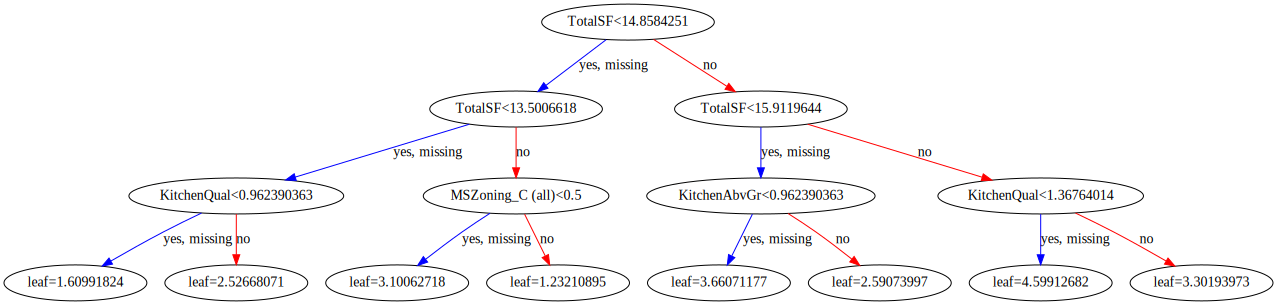

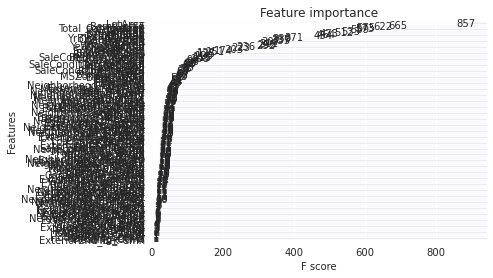

In [116]:
import graphviz
model_xgb.fit(train, y_train,  verbose=False) #  eval_set=[(X_test, y_test)]
xgb.plot_importance(model_xgb)
xgb.to_graphviz(model_xgb, num_trees=20)

In [117]:
print("Optimize LightGBM: ", datetime.datetime.now())

Optimize LightGBM:  2020-07-21 09:48:12.193412


- **LightGBM** :

In [118]:
tuning_lgb = 0
if (tuning_lgb == 1):
    # initialize the algorithm for the GridSearchCV function
    #model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=- 1, 
    #                            subsample_for_bin=200000, 
    #                            objective='regression',num_leaves=5,
    #                            learning_rate=0.05, n_estimators=720,
    #                            class_weight=None, min_split_gain=0.0, 
    #                            min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
    #                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
    #                            random_state=None, n_jobs=- 1, silent=True, importance_type='split')

    lgb1 = lgb.LGBMRegressor()
    tuningLGB = 0

    if (tuningLGB == 1):
        # use this when tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5,6], # - done
            'learning_rate':[0.05], # - done
            'n_estimators':[650,750], # - done
            'max_bin':[45,55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[500,1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }
    else:
        # use this when not tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5], # - done, maybe 5 is okay too
            'learning_rate':[0.05], # - done
            'n_estimators':[650], # - done
            'max_bin':[55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=lgb1,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


In [119]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
if (tuning_lgb == 1):
    model_lgb_op = lgb.LGBMRegressor(**grid_result.best_params_)
else:
    lgbm = {'bagging_fraction': 0.85, 'bagging_freq': 5, 'bagging_seed': 9, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'feature_fraction': 0.2319, 'feature_fraction_seed': 9, 'importance_type': 'split', 'learning_rate': 0.05, 'max_bin': 55, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_data_in_leaf': 9, 'min_split_gain': 0.0, 'min_sum_hessian_in_leaf': 11, 'n_estimators': 650, 'num_leaves': 5, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 1000, 'subsample_freq': 0}
    model_lgb_op = lgb.LGBMRegressor(**lgbm)

- **BayesianRidge** :

In [120]:
# initialize the algorithm for the GridSearchCV function
br = BayesianRidge()
tuningBR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningBR == 1):
    # use this when tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

else:
    # use this when not tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=br,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 2.0963268280029297 seconds to complete
Best mae 63.666994 using {'alpha_1': 1e-06, 'alpha_2': 1e-05, 'alpha_init': None, 'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 50, 'normalize': False, 'tol': 0.001, 'verbose': False}
The function took 8.726047992706299 seconds to complete
nested mae score from KFold 65.594
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=BayesianRidge(),
             param_grid={'alpha_1': [1e-06], 'alpha_2': [1e-05],
                         'alpha_init': [None], 'compute_score': [True, False],
                         'copy_X': [True], 'fit_intercept': [True, False],
                         'lambda_1': [1e-05], 'lambda_2': [1e-06],
                         'lambda_init': [None], 'n_iter': [50],
                         'normalize': [False, True], 'tol': [0.001],
                      

In [121]:
tuning_br = 0
BR = BayesianRidge()
if (tuning_br == 1):
    BR_new = BayesianRidge(**grid_result.best_params_)

In [122]:
rd = result_details(grid_result,'alpha_1',100)
rd[['alpha_1','alpha_2','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

,alpha_1,alpha_2,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,0.000,0.000,8.054,1.881,5.647,-0.149,-0.914,-0.003
1,0.000,0.000,8.272,2.209,5.756,-0.216,-0.910,-0.007
2,0.000,0.000,8.081,1.877,5.672,-0.146,-0.914,-0.003
3,0.000,0.000,8.081,1.877,5.672,-0.146,-0.914,-0.003
4,0.000,0.000,8.054,1.881,5.647,-0.149,-0.914,-0.003
5,0.000,0.000,8.272,2.209,5.756,-0.216,-0.910,-0.007
6,0.000,0.000,8.081,1.877,5.672,-0.146,-0.914,-0.003
7,0.000,0.000,8.081,1.877,5.672,-0.146,-0.914,-0.003


In [123]:
if (tuning_br == 1):
    model_results = [] # model flow, mae, rmsle
    models = [BR, BR_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **More Models** :

In [124]:
# initialize the algorithm for the GridSearchCV function
# defaults are best
ET = ExtraTreesRegressor()
tuningET = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningET == 1):
    # use this when tuning
    param_grid={
        'n_estimators':[100], # revisit at possibly 2000, but this algorithm becomes really slow for large values
        'criterion':['mse'], # done Default: mse, mae
        'max_depth':[None], # done - above 30 result converges to None
        'min_samples_split':[2], # done - inconsistently better
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'], # done - Default:“auto”, “sqrt”, “log2”, None
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False], # done - True doesn't work, results in a nan value
        'n_jobs':[None],
        'random_state':[1,5,42,55,98],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None] # done - no difference
    }

else:
    # use this when not tuning
    param_grid={
        'n_estimators':[100],
        'criterion':['mse'],
        'max_depth':[None],
        'min_samples_split':[2],
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False],
        'n_jobs':[None],
        'random_state':[None],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ET,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 13.963160276412964 seconds to complete
Best mae 76.401548 using {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
The function took 44.46495962142944 seconds to complete
nested mae score from KFold 69.245
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [False], 'ccp_alpha': [0.0],
                         'criterion': ['mse'], 'max_depth': [None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrea

In [125]:
rd = result_details(grid_result,'mean_test_nmse',100)
rd[['random_state','n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

,random_state,n_estimators,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,None,100,8.512,2.983,5.904,-0.304,-0.904,-0.013


In [126]:
#ET = make_pipeline(RobustScaler(), ExtraTreesRegressor()) # was 1 Tree algorithms don't need scaling
tuning_et = 0
if (tuning_et == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)
        ET = ExtraTreesRegressor(random_state=i)
        #ET2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(random_state=i))

        e = {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'verbose': 0, 'warm_start': False}
        ET_new = ExtraTreesRegressor(**e, random_state=i)
        #ET_new2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(**e, random_state=i))

        model_results = [] # model flow, mae, rmsle
        models = [ET, ET_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    ET_new = make_pipeline(RobustScaler(), ExtraTreesRegressor(**grid_result.best_params_))

In [127]:
# initialize the algorithm for the GridSearchCV function
R = Ridge(alpha=1.0)
tuningR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningR == 1):
    # use this when tuning
    param_grid={
        'alpha':[8], # done
        'fit_intercept':[True], # done
        'normalize':[False], # done
        'copy_X':[True],
        'max_iter':[None], # done - no difference
        'tol':[0.001],
        'solver':['auto'], # done - Default:‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
        'random_state':[1,10,42,99,127]
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[1.0],
        'fit_intercept':[True],
        'normalize':[False],
        'copy_X':[True],
        'max_iter':[None],
        'tol':[0.001],
        'solver':['auto'],
        'random_state':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=R,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(5, train, y_train)

Running GridSearchCV:
The function took 0.6442594528198242 seconds to complete
Best mae 63.578314 using {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 1, 'solver': 'auto', 'tol': 0.001}
The function took 2.051549196243286 seconds to complete
nested mae score from KFold 64.692
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [8], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [None],
                         'normalize': [False],
                         'random_state': [1, 10, 42, 99, 127],
                         'solver': ['auto'], 'tol': [0.001]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2

In [128]:
rd = result_details(grid_result,'mean_test_nmse',100)
summary = rd[['alpha','random_state','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])
#summary.groupby(['fit_intercept'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_nmse': 'std', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])
summary.groupby(['alpha'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])


,alpha,mean_test_nmse,mean_test_mae,mean_test_r2
0,8,7.999,5.625,-0.916


In [129]:
#R = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1)) # was 1
tuning_r = 1
if (tuning_r == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        r= {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001}
        #R_new = make_pipeline(RobustScaler(), Ridge(**r, random_state=i))
        R_new = Ridge(**r, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [R, R_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    #R_new = make_pipeline(RobustScaler(), Ridge(**grid_result.best_params_))
    R_new = Ridge(**grid_result.best_params_)

random_state = 2
running cross_validate

 mae_cv score: 5.7981 (0.1769)


 rmsle_cv score: 8.2843 (10.0105)


 r2_cv score: 0.9095 (0.0083)

The function took 0.05204319953918457 seconds to complete
running cross_validate

 mae_cv score: 5.6695 (0.1348)


 rmsle_cv score: 8.0643 (9.4966)


 r2_cv score: 0.9142 (0.0081)

The function took 0.05192422866821289 seconds to complete
                            model   mae  rmsle    r2
1  Ridge(alpha=8, random_state=2) 5.669  8.064 0.914
0                         Ridge() 5.798  8.284 0.910
random_state = 5
running cross_validate

 mae_cv score: 5.7981 (0.1769)


 rmsle_cv score: 8.2843 (10.0105)


 r2_cv score: 0.9095 (0.0083)

The function took 0.052961111068725586 seconds to complete
running cross_validate

 mae_cv score: 5.6695 (0.1348)


 rmsle_cv score: 8.0643 (9.4966)


 r2_cv score: 0.9142 (0.0081)

The function took 0.05267620086669922 seconds to complete
                            model   mae  rmsle    r2
1  Ridge(alpha=8, random_st

In [130]:
AB = AdaBoostRegressor()
SVR = SVR()
DT = DecisionTreeRegressor()
KN = KNeighborsRegressor()
B = BaggingRegressor()

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [131]:
if (tuning_gb == 1):
    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_orig]#, GBoost] # model_lgb_op, lasso_ns, 

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

Calculate Metrics for model list

In [132]:
print("Calculate Metrics: ", datetime.datetime.now())

Calculate Metrics:  2020-07-21 09:50:41.971199


In [133]:
compare_models = 0
if (compare_models == 1):
    model_results = [] # model flow, mae, rmsle
    # GBoost is better than GBoost_orig, but has lower final score, think this may be  overfitting
    # BR_new has same results, here, but better final score
    models = [lasso, lasso_new, ENet, ENet_new, KRR, GBoost_orig, GBoost, model_xgb, model_lgb, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B, R, R_new] # worse or same: BR_new, model_lgb_op, lasso_ns, model_xgb_new,

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

In [134]:
print("Stacking and Ensembling: ", datetime.datetime.now())

Stacking and Ensembling:  2020-07-21 09:50:41.999347


##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn BaseEstimator, RegressorMixin, TransformerMixin classes with our model and also to leverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

In [135]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        # IDEA: return weighted means
        return np.mean(predictions, axis=1)


**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [136]:
#AveragingModels will fit and predict each model and predict using the mean of the individual predictions
with MyTimer():
    averaged_models = AveragingModels(models = (model_lgb, model_xgb, GBoost_orig, KRR, BR)) # Adding ENet and RF is worse, model_xgb_new is worse
    #averaged_models = AveragingModels(models = (GBoost))

if (competition == 'SR'):
    score = mae_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
else:
    score = rmsle_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

The function took 1.049041748046875e-05 seconds to complete
running mae_cv code
[09:50:42] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:50:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but 

In [137]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
averaged_pred = inv_boxcox1p(averaged_models.predict(test.values), lam_l)

if (competition == 'SR'):
    print(mae(y_train, averaged_train_pred))
else:
    print(rmsle(y_train, averaged_train_pred))

[09:52:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


2.497064334591457


In [138]:
averaged_pred

array([121947.44252631, 167880.62784238, 187385.70863707, ...,
       166074.14488729, 111218.37689349, 220350.22157572])

In [139]:
use_average = 0 # AveragingModels Averages
#use_average = 1 # VotingRegressor Averages
if (use_average == 1):
    from sklearn.ensemble import VotingRegressor

    e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
    r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'cv': None, 'gcv_mode': 'auto', 'random_state': 99} #  
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}

    # ('enet', make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3)))
    estimator_list = [('xgb', xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state=7)),
                  ('lgb', lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)),
                  ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                  ('krr', KernelRidge(**k)),
                  ('br', BayesianRidge())]

    ereg = VotingRegressor(estimators=estimator_list, weights=[1,1,1,1,1]) 
    ereg = ereg.fit(train, y_train)
    averaged_pred = inv_boxcox1p(ereg.predict(test), lam_l)
    averaged_pred

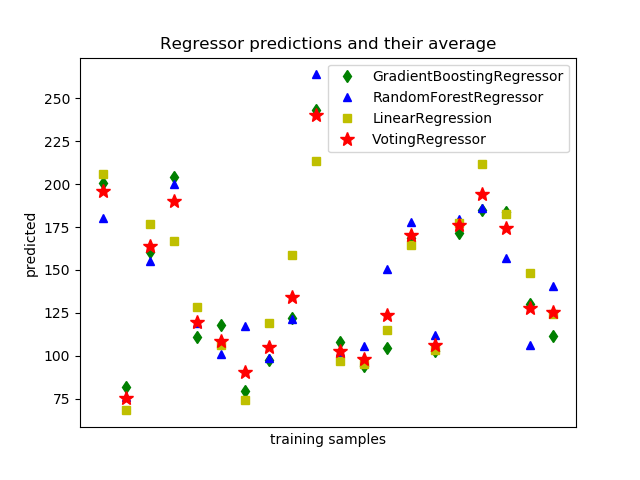

###Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


Another way to combine multiple models:

The function cross_val_predict is appropriate for:
Visualization of predictions obtained from different models.

Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image source [Faron](https://www.kaggle.com/getting-started/18153#post103381))

The only difference between M6 and M1-M5 is, that M6 is trained on the entire original training data, whereas M1-M5 are trained only on 4 out of 5 folds.

With M1-M5 you can build valid out-of-fold predictions for the training set (the orange ones) to form a "new feature" for the 2nd layer (not possible with M6). You can also predict the test set with M1-M5 to get 5 sets of test set predictions .. but you only need one set of test set predictions for the corresponding feature to the orange out-of-fold train set predictions.

Hence, you reduce those 5 sets to 1 by averaging. That's the first variant. Alternatively, you train M6 and use its test set predictions as feature for the 2nd layer (instead of the average of the test set predictions from M1-M5).

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [140]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10): # increasing this value should give a more accurate prediction, averaged over n_fold iterations
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) # was 156
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models): # for each model passed in
            for train_index, holdout_index in kfold.split(X, y): # create train,test for the number of folds
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index]) # fit the model for this fold
                y_pred = instance.predict(X[holdout_index]) # predict values for this fold
                out_of_fold_predictions[holdout_index, i] = y_pred # think we either use all of these values as features later, or the mean value?
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new and only feature
        print("out_of_fold_predictions", out_of_fold_predictions)
        self.meta_model_.fit(out_of_fold_predictions, y) # need to see out_of_fold_predictions feature set
        return self
   
    # Calculate the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is calculated by the meta-model
    def predict(self, X):
        # column_stack() function is used to stack 1-D arrays as columns into a 2-D array.
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Diagram of out of fold cross validated stacked models


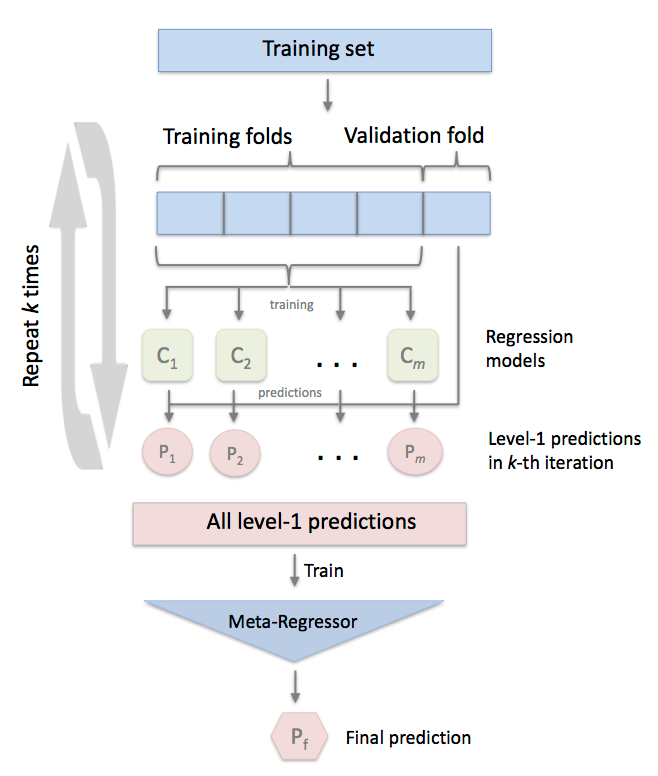

Reference: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

**Stacking Averaged models Score**

In [141]:
# ~ 10 minutes to run

#stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), # adding RF here did not help
#                                                 meta_model = lasso)
# verify: this class uses out of fold predictions in the stacking method, so rows in dataset are split up betwen models and each row in dataset is only used once
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost_orig, KRR, BR), # adding RF here did not help
                                                 meta_model = R_new)

if (compare_models == 1):
    with MyTimer():
        if (competition == 'SR'):
            score = mae_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))
        else:
            score = rmsle_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [142]:
stacked_averaged_models

StackingAveragedModels(base_models=(Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('elasticnet',
                                                     ElasticNet(alpha=0.05,
                                                                l1_ratio=0.85,
                                                                max_iter=100,
                                                                random_state=3,
                                                                selection='random'))]),
                                    GradientBoostingRegressor(learning_rate=0.05,
                                                              loss='huber',
                                                              max_depth=4,
                                                              max_features='sqrt',
                                                              min_samples

use different function to calculate ensembles

In [143]:
use_Regressor = 0 # default - best score
#use_Regressor = 1 # StackingRegressor - worst score
#use_Regressor = 2 # StackingCVRegressor - middle score

if (use_Regressor == 1):
    from sklearn.ensemble import StackingRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 1
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=RidgeCV(**r))
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'cv': None, 'gcv_mode': 'auto', 'random_state': 99} #  
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(**r))

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test.values), lam_l)
    #reg.transform(inv_boxcox1p(stacked_averaged_models2, lam_l))
    print(stacked_pred)
    print(reg)

multilayer stacking

In [144]:
a='''
# Note Multiple stacking layers can be achieved by assigning final_estimator to a StackingClassifier or StackingRegressor:

final_layer = StackingRegressor(
    estimators=[('rf', RandomForestRegressor(random_state=42)),
                ('gbrt', GradientBoostingRegressor(random_state=42))],
    final_estimator=RidgeCV()
    )
multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
                ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
    final_estimator=final_layer
)
multi_layer_regressor.fit(X_train, y_train)'''

Use another Stacking function, from mlxtend

In [145]:
if (use_Regressor == 2):
    from mlxtend.regressor import StackingCVRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 0
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        enet = make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = RidgeCV(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'random_state': 99} #  
        enet = make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = Ridge(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test.values), lam_l)
    print(stacked_pred)
    print(reg)
    
    print('5-fold cross validation scores:\n')
    for clf, label in zip([enet, gboost, krr, br], ['enet', 'gboost', 
                                                'krr', 'br',
                                                'StackingCVRegressor']):
        scores = cross_val_score(clf, train, y_train, cv=5, scoring='neg_mean_squared_error')
        print("Neg. MSE Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
        #scores = cross_val_score(clf, train, y_train, cv=5)
        #print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the **StackedRegressor** defined previously. 

###Final Training and Prediction

**StackedRegressor:**

add the previous averaged models here

In [146]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
if (use_average == 0):
    averaged_pred = inv_boxcox1p(averaged_models.predict(test.values), lam_l)

if (competition == 'SR'):
    print(mae(y_train, averaged_train_pred))
else:
    print(rmsle(y_train, averaged_train_pred))

[09:52:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


2.497064334591457


In [147]:
#pre adjustment
averaged_pred

array([121947.44252631, 167880.62784238, 187385.70863707, ...,
       166074.14488729, 111218.37689349, 220350.22157572])

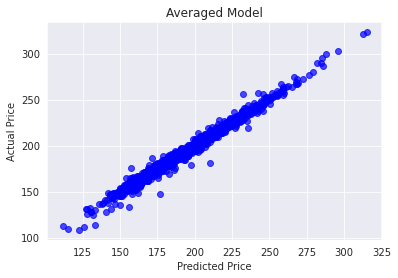

In [148]:
plt.scatter(averaged_train_pred, y_train, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')
plt.show()

Check predictions, are they one same scale as SalePrice in Train dataset?

In [149]:
averaged_models.predict(test.values)

array([169.36684692, 189.75473515, 197.30895815, ..., 189.02677606,
       163.90409715, 208.98988117])

In [150]:
averaged_train_pred

array([204.57291305, 194.58110141, 208.28424851, ..., 222.72356673,
       177.60715706, 183.08759078])

In [151]:
#post adjustment
averaged_pred

array([121947.44252631, 167880.62784238, 187385.70863707, ...,
       166074.14488729, 111218.37689349, 220350.22157572])

In [152]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
if (use_Regressor == 0):
    stacked_pred = inv_boxcox1p(stacked_averaged_models.predict(test.values), lam_l)
    
with MyTimer():
    if (competition == 'SR'):
        print(mae(y_train, stacked_train_pred))
    else:
        print(rmsle(y_train, stacked_train_pred))

out_of_fold_predictions [[204.26919235 205.64941267 205.45092258 203.54236946]
 [196.33751596 191.64483904 193.02548542 196.40533558]
 [207.2400321  205.16598471 208.2546137  207.44641725]
 ...
 [231.74622669 213.00004935 216.81664653 220.68592471]
 [177.13500493 178.43958575 170.21693908 175.76492909]
 [181.65163454 182.5132125  182.98024601 183.79617324]]
2.609007568268325
The function took 0.0005583763122558594 seconds to complete


In [153]:
stacked_pred

array([119697.21608709, 172530.13027807, 187453.06095491, ...,
       163515.77580729, 110755.37298251, 220556.68401766])

In [154]:
print(y_train)
print(stacked_train_pred)
print(stacked_pred)

[204.93054257 195.08561344 210.04487143 ... 223.56899073 178.84819785
 181.2243778 ]
[205.30374619 195.11557808 208.68254698 ... 223.58761348 177.5536241
 182.02056081]
[119697.21608709 172530.13027807 187453.06095491 ... 163515.77580729
 110755.37298251 220556.68401766]


In [155]:
def fit_pred(train, ytrain, test, model):
        model.fit(train, y_train)
        model_train_pred = model.predict(train)
        model_pred = inv_boxcox1p(model.predict(test), lam_l)
        return(model_train_pred, model_pred)
    
models = [lasso, lasso_new, ENet, KRR, GBoost_orig, GBoost, model_xgb, model_xgb_new, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B] # model_lgb,
model_names = ['lasso', 'lasso_new', 'ENet', 'KRR', 'GBoost_orig', 'GBoost', 'model_xgb', 'model_xgb_new', 'BR', 'ET', 'ET_new', 'RF', 'RF_new', 'AB', 'SVR', 'DT', 'KN', 'B']

with MyTimer():
    for i in range(0,len(models)):
        mn = model_names[i]+"_pred"
        train_pred, test_pred = fit_pred(train, y_train, test, models[i])
        print(mn, test_pred)    


lasso_pred [121133.83973913 165828.69964909 184971.95812617 ... 172698.23783602
 120174.54480598 221886.33285089]
lasso_new_pred [117913.16873518 153212.76235918 184531.4274212  ... 173493.9187348
 119313.60938475 221638.12221288]
ENet_pred [118760.38109268 164241.40257948 185315.55826444 ... 171585.29384325
 119797.01155727 220952.6055887 ]
KRR_pred [115041.06859991 197022.77013591 182943.84105357 ... 161528.48566495
 102519.69252921 222785.82227888]
GBoost_orig_pred [122380.5317529  159297.18674045 195738.22135333 ... 153842.43708988
 114355.08606854 214175.37785181]
GBoost_pred [126341.12061267 162523.91230796 200368.05955125 ... 156819.50098483
 119210.48991445 217897.07133875]
[09:55:37] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if

Create predictions for all models for testing

**XGBoost:**

In [156]:
# values are not normalized
train[train.columns].mean().head()

MSSubClass     2.305
LotFrontage    5.898
LotArea       19.549
Street         0.727
Alley          0.718
dtype: float64

In [157]:
# are train and test normalized? between -1 and 1
replace_xgb = 0 # new optimized model is worse, was overfit
if (replace_xgb == 1):
    model_xgb_new.fit(train, y_train)
    xgb_train_pred = model_xgb_new.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb_new.predict(test), lam_l)
else:
    model_xgb.fit(train, y_train)
    xgb_train_pred = model_xgb.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb.predict(test), lam_l)

if (competition == 'SR'):
    print(mae(y_train, xgb_train_pred))
else:
    print(rmsle(y_train, xgb_train_pred))

[09:55:57] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.0214801473885704


**LightGBM:**

In [158]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = inv_boxcox1p(model_lgb.predict(test.values), lam_l)

if (competition == 'SR'):
    print(mae(y_train, lgb_train_pred))
else:
    print(rmsle(y_train, lgb_train_pred))

3.4257991540907495


In [159]:
if (tuning_lgb == 1):
    model_lgb_op.fit(train, y_train)
    lgb_train_pred_op = model_lgb_op.predict(train)
    lgb_pred_op = inv_boxcox1p(model_lgb_op.predict(test.values), lam_l)

    if (competition == 'SR'):
        print(mae(y_train, lgb_train_pred_op))
    else:
        print(rmsle(y_train, lgb_train_pred_op))

In [160]:
# compare values with optimization
print(lgb_train_pred)
if (tuning_lgb == 1):
    print(lgb_train_pred_op)
print(lgb_pred)
if (tuning_lgb == 1):
    print(lgb_pred_op)

[203.67611878 191.8459941  206.83074    ... 222.94048261 177.72033626
 186.0114241 ]
[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]


In [161]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')


stk = 0.70
xgb = 0.15
lgb = 0.15


if (competition == 'SR'):
    print(mae(y_train,stacked_train_pred*stk + xgb_train_pred*xgb + lgb_train_pred*lgb ))
else:
    print(rmsle(y_train,stacked_train_pred*stk + xgb_train_pred*xgb + lgb_train_pred*lgb ))

RMSLE score on train data:
2.388668732422424


Seems that RMSLE does not correlate to a good score

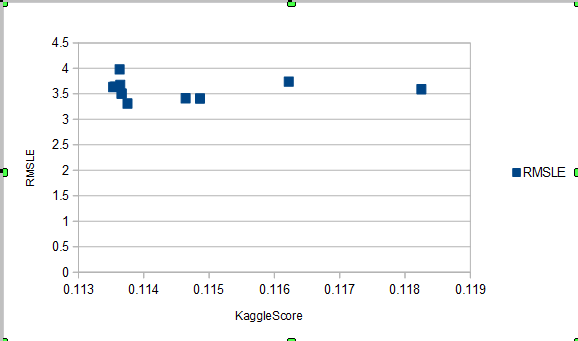

**Ensemble prediction:**

when deciding which models to include in an ensemble:  
    fewer are better  
    more diverse are better  

In [162]:
#method = 'ensemble'
method = 'stacked'
if (method == 'stacked'):
    #stacked_pred => ENet, GBoost_orig, KRR
    ensemble = stacked_pred*stk + xgb_pred*xgb + lgb_pred*lgb  # if using averaged_pred, need to add averaged_pred here
else:
    ensemble = averaged_pred


In [163]:
print(lgb_pred)
print(xgb_pred)
print(stacked_pred)
print(averaged_pred)
print(ensemble)

[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]
[127367.695 163507.66  186504.55  ... 176893.8   106397.68  215797.77 ]
[119697.21608709 172530.13027807 187453.06095491 ... 163515.77580729
 110755.37298251 220556.68401766]
[121947.44252631 167880.62784238 187385.70863707 ... 166074.14488729
 111218.37689349 220350.22157572]
[121835.90713634 169373.25829338 187147.85963502 ... 165674.75166868
 111025.33182747 221012.72691441]


In [164]:
print(y_train,stacked_train_pred * stk + xgb_train_pred * xgb + lgb_train_pred * lgb) # if using averaged_pred, need to add averaged_pred here
print(y_train,stacked_train_pred)

[204.93054257 195.08561344 210.04487143 ... 223.56899073 178.84819785
 181.2243778 ] [204.92838685 194.50238843 208.53113915 ... 223.52641459 177.65061775
 182.5503286 ]
[204.93054257 195.08561344 210.04487143 ... 223.56899073 178.84819785
 181.2243778 ] [205.30374619 195.11557808 208.68254698 ... 223.58761348 177.5536241
 182.02056081]


Plot prediction vs actual for train for one last verification of the model

In [165]:
sub_train = pd.DataFrame()
sub_train['Id'] = train_ID
sub_train['SalePrice'] = inv_boxcox1p(stacked_train_pred, lam_l)

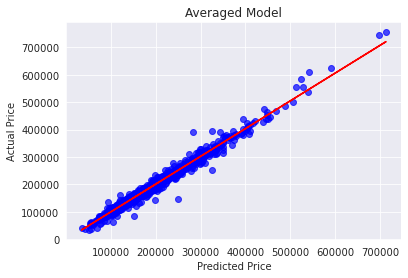

In [166]:
Predicted = sub_train['SalePrice']
Actual = inv_boxcox1p(y_train, lam_l)
plt.scatter(sub_train['SalePrice'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

At the high end, SP > 520000, the model predicts too low for 7/8 points

Get Pre-adjustment score for comparison

In [167]:
# Pre-adjustment score
print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice']))
print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice']))
print("mae for SalePrice",mae(Actual, Predicted))
print("mse for SalePrice",rmsle(Actual, Predicted))

mae for boxcox(SalePrice) 180530.18755356077
mse for boxcox(SalePrice) 196515.2768378298
mae for SalePrice 6719.9212993537885
mse for SalePrice 10752.768488152702


Find best cutoff and adjustment at high end

In [168]:
AdjustedScores = []

for i in np.arange(.994, .996, 0.001):
    for j in np.arange(1.06, 1.08, .01):

        q1 = sub_train['SalePrice'].quantile(0.0025)
        q2 = sub_train['SalePrice'].quantile(0.0045)
        q3 = sub_train['SalePrice'].quantile(i)

        #Verify the cutoffs for the adjustment
        print(q1,q2,q3)
        # adjust at low end
        #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
        #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

        # adjust at high end
        sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

        Predicted = sub_train['SalePrice2']
        Actual = inv_boxcox1p(y_train, lam_l)

        # Pre-adjustment score
        print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
        print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
        print("mae for SalePrice",mae(Actual, Predicted))
        print("mse for SalePrice",rmsle(Actual, Predicted))

        AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])

df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])

53763.32914391052 55719.3174772021 492563.5984850428
mae for boxcox(SalePrice) 180742.3474555779
mse for boxcox(SalePrice) 197161.61067789025
mae for SalePrice 6605.437266167834
mse for SalePrice 10384.263060863204
53763.32914391052 55719.3174772021 492563.5984850428
mae for boxcox(SalePrice) 180777.70743924743
mse for boxcox(SalePrice) 197272.78137311275
mae for SalePrice 6610.723426287302
mse for SalePrice 10391.174012220215
53763.32914391052 55719.3174772021 492563.5984850428
mae for boxcox(SalePrice) 180813.06742291694
mse for boxcox(SalePrice) 197384.93293208518
mae for SalePrice 6624.438581719537
mse for SalePrice 10417.869634580817
53763.32914391052 55719.3174772021 511166.4670191847
mae for boxcox(SalePrice) 180721.49353360484
mse for boxcox(SalePrice) 197106.42522487935
mae for SalePrice 6584.583344194758
mse for SalePrice 10343.78712682542
53763.32914391052 55719.3174772021 511166.4670191847
mae for boxcox(SalePrice) 180753.37786361214
mse for boxcox(SalePrice) 197208.1205485

In [169]:
q1 = sub_train['SalePrice'].quantile(0.0015)
q2 = sub_train['SalePrice'].quantile(0.01)
q3 = sub_train['SalePrice'].quantile(0.995)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*1.07)

51872.6689119195 69299.61586611377 511166.4670191847


Show adjustments

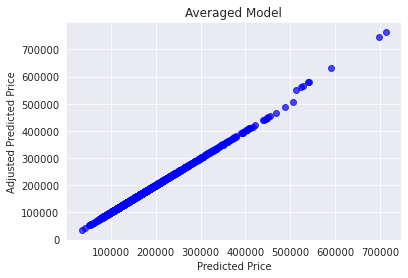

In [170]:
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

We have bumped up the predictions and they look correct so far, now to verify on the previous chart

In [171]:
sub_train.query("SalePrice != SalePrice2")

,Id,SalePrice,SalePrice2
440,441,529326.229,566379.065
691,692,713118.283,763036.563
769,770,540421.024,578250.496
803,804,523169.503,559791.368
898,899,541811.720,579738.540
1046,1047,512926.756,548831.629
1169,1170,590928.534,632293.531
1182,1183,697033.266,745825.595


Show new predictions

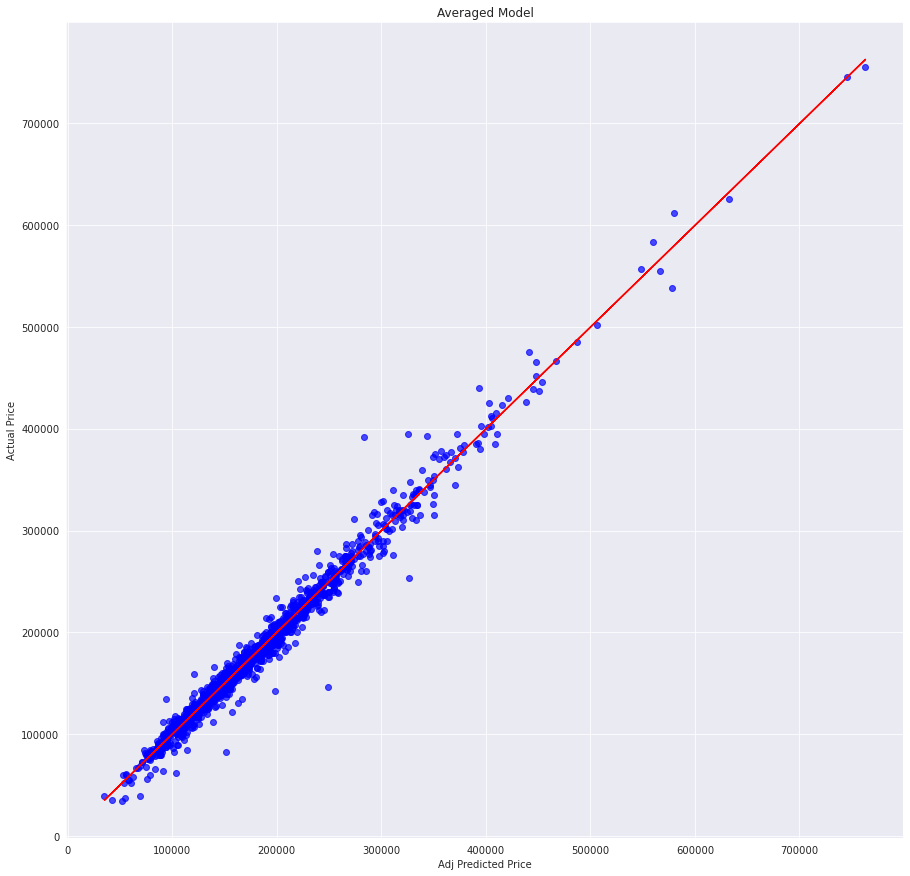

In [172]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

correlation looks much better at the high end

In [173]:
# Post adjustment for high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180753.37786361214
mse for boxcox(SalePrice2) 197208.120548542
mae for SalePrice2 6586.393850652045
mse for SalePrice2 10338.007001494221


Now try to improve upon this

Find best cutoff and adjustment at low end

In [174]:
#sub_train = pd.DataFrame()
#sub_train['Id'] = train_ID
#sub_train['SalePrice'] = inv_boxcox1p(stacked_train_pred, lam_l)
q1 = sub_train['SalePrice'].quantile(0.013)
q2 = sub_train['SalePrice'].quantile(0.10)
q3 = sub_train['SalePrice'].quantile(0.995)
print(q1,q2,q3)

74025.01094787024 104896.61197270197 511166.4670191847


In [175]:
sub_train.min()

Id               1.000
SalePrice    35342.549
SalePrice2   35342.549
dtype: float64

In [176]:
AdjustedScores = []

for i in np.arange(.005, .015, 0.001):
    for j in np.arange(.90, 1.00, 0.01):

        q1 = sub_train['SalePrice'].quantile(i)
        q2 = sub_train['SalePrice'].quantile(0.1)
        q3 = sub_train['SalePrice'].quantile(.995)

        #Verify the cutoffs for the adjustment
        print(q1,q2,q3)
        # adjust at low end
        sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*j)
        #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

        # adjust at high end
        #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

        Predicted = sub_train['SalePrice2']
        Actual = inv_boxcox1p(y_train, lam_l)

        # Pre-adjustment score
        print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
        print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
        print("mae for SalePrice",mae(Actual, Predicted))
        print("mse for SalePrice",rmsle(Actual, Predicted))

        AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])

df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])

56457.13320369409 104896.61197270197 511166.4670191847
mae for boxcox(SalePrice) 180502.53090209528
mse for boxcox(SalePrice) 196508.42296781973
mae for SalePrice 6724.726324169417
mse for SalePrice 10751.884559416312
56457.13320369409 104896.61197270197 511166.4670191847
mae for boxcox(SalePrice) 180505.29656724184
mse for boxcox(SalePrice) 196509.07581870907
mae for SalePrice 6724.008706392095
mse for SalePrice 10751.378094261498
56457.13320369409 104896.61197270197 511166.4670191847
mae for boxcox(SalePrice) 180508.0622323884
mse for boxcox(SalePrice) 196509.73590004348
mae for SalePrice 6723.29108861477
mse for SalePrice 10751.003805719261
56457.13320369409 104896.61197270197 511166.4670191847
mae for boxcox(SalePrice) 180510.82789753494
mse for boxcox(SalePrice) 196510.40321175003
mae for SalePrice 6722.573470837446
mse for SalePrice 10750.76170759482
56457.13320369409 104896.61197270197 511166.4670191847
mae for boxcox(SalePrice) 180513.5935626815
mse for boxcox(SalePrice) 196511

In [177]:
df_adj.sort_values(by=['RMSE_BC'])

,QUANT,COEF,MAE_BC,RMSE_BC,MAE_SP,RMSE_SP
51,0.010,0.910,2.610,3.968,6720.739,10741.246
52,0.010,0.920,2.608,3.968,6718.774,10741.286
50,0.010,0.900,2.612,3.969,6722.705,10741.515
53,0.010,0.930,2.607,3.969,6716.808,10741.637
54,0.010,0.940,2.605,3.971,6714.917,10742.298
...,...,...,...,...,...,...
49,0.009,0.990,2.608,3.989,6718.999,10751.505
29,0.007,0.990,2.608,3.989,6718.681,10751.546
19,0.006,0.990,2.609,3.990,6719.496,10751.975
9,0.005,0.990,2.609,3.990,6719.895,10752.085


In [178]:
q1 = sub_train['SalePrice'].quantile(0.01)
q2 = sub_train['SalePrice'].quantile(0.1)
q3 = sub_train['SalePrice'].quantile(0.995)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.91) # also try .94
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*1.07)

69299.61586611377 104896.61197270197 511166.4670191847


Show both adjustments

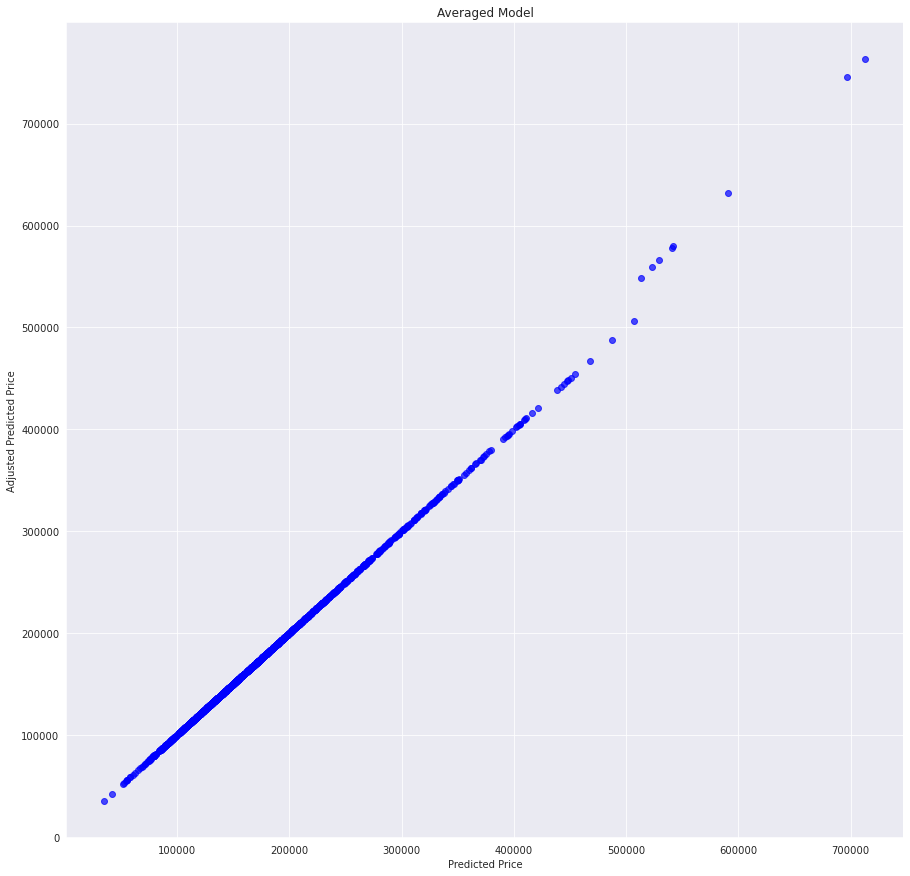

In [179]:
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

Show new predictions

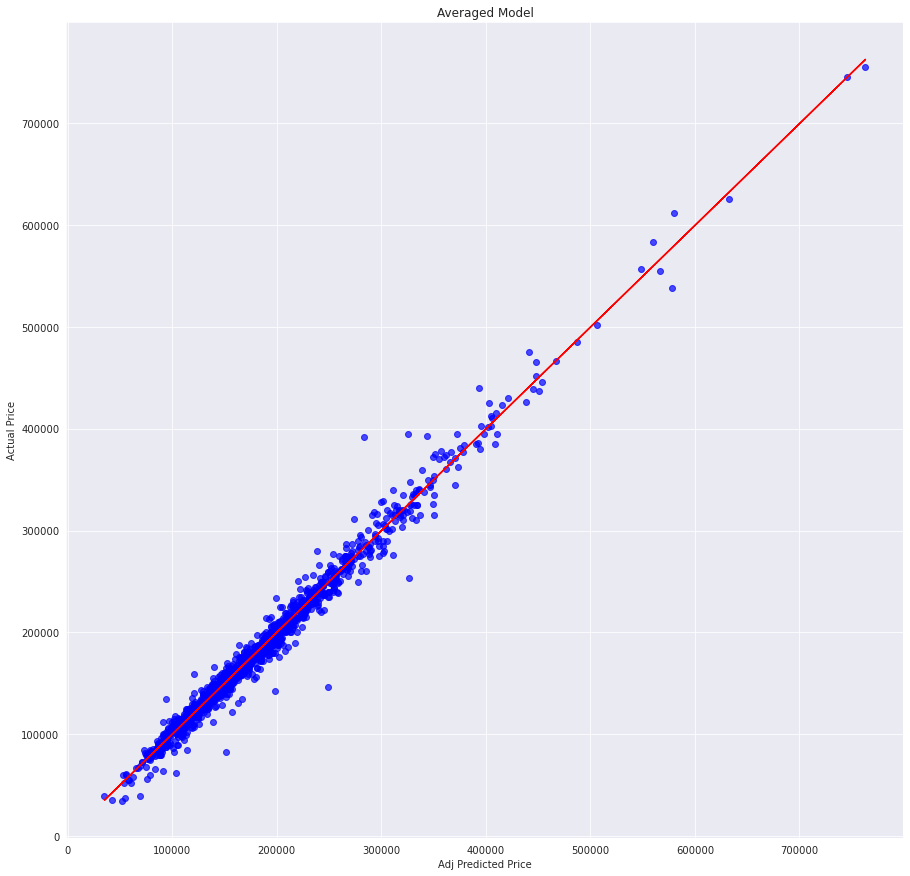

In [180]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')

plt.show()

In [181]:
sub_train.query("SalePrice != SalePrice2")

,Id,SalePrice,SalePrice2
440,441,529326.229,566379.065
691,692,713118.283,763036.563
769,770,540421.024,578250.496
803,804,523169.503,559791.368
898,899,541811.720,579738.540
1046,1047,512926.756,548831.629
1169,1170,590928.534,632293.531
1182,1183,697033.266,745825.595


In [182]:
# Post adjustment for low and high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180753.37786361214
mse for boxcox(SalePrice2) 197208.120548542
mae for SalePrice2 6586.393850652045
mse for SalePrice2 10338.007001494221


**Create File for Submission to Kaggle**

In [183]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
#sub.to_csv('submission.csv',index=False)

Making the same adjustment on the test data for our submission

In [184]:
q1 = sub['SalePrice'].quantile(0.01)
q2 = sub['SalePrice'].quantile(0.1)
q3 = sub['SalePrice'].quantile(0.995)

# adjust at low end
#sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if x > q1 else x*0.99) # didn't help, with several values
#sub['SalePrice2'] = sub['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if x < q3 else x*1.07)

In [185]:
sub.to_csv('submission.csv',index=False)

In [186]:
sub.head()

,Id,SalePrice
0,1461,121835.907
1,1462,169373.258
2,1463,187147.860
3,1464,193822.259
4,1465,195009.492


In [187]:
!pwd

/kaggle/working


In [188]:
ls -arlt

total 784
drwxr-xr-x 6 root root   4096 Jul 21 09:43 ../
---------- 1 root root 754275 Jul 21 09:43 __notebook__.ipynb
drwxr-xr-x 2 root root   4096 Jul 21 09:56 ./
-rw-r--r-- 1 root root  34444 Jul 21 09:56 submission.csv


In [189]:
!head -10 submission.csv

Id,SalePrice
1461,121835.90713633555
1462,169373.25829337595
1463,187147.85963501848
1464,193822.2594422755
1465,195009.49226040783
1466,174067.29941712823
1467,177078.30728142758
1468,165232.7201763103
1469,176806.45848950406


In [190]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-07-21 09:43:34.989946
End:  2020-07-21 09:56:10.678361


In [191]:
from mlens.ensemble import SuperLearner
ensemble = SuperLearner(random_state=1, verbose=2)

[MLENS] backend: threading


try different pipelines, scaler, etc
reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

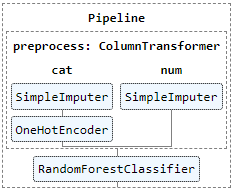

Try polynomial features:
reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=degrees[i],
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])

scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                         scoring="neg_mean_squared_error", cv=10)       
                             
                             
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lda', LinearDiscriminantAnalysis()))
model = Pipeline(estimators)    


features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model = Pipeline(estimators)